In [421]:
import pandas as pd
import numpy as np
from sympy import init_printing
import cv2
from PIL import Image
init_printing()

In [35]:
fe = pd.read_csv('fullevents.csv')
pe = pd.read_csv('passingevents.csv')
m = pd.read_csv('matches.csv')

#将坐标统一！
def convert_coor(row):
    if row[1].startswith('Opponent'):
        for i in range(1,5):
            row[-i] = 100-row[-i]
    return row
def convert_goal_keeper(row):
    if row[6] != 'Pass':
        if str(row[2])[:-1].endswith('G'):
            row[-3] = 50
            if row[1].startswith('Opponent'):
                row[-4] = 100
        elif str(row[3])[:-1].endswith('G'):
            row[-1] = 50
            if row[1].startswith('Opponent'):
                row[-2] = 100
    return row
def add_time_2H(row):
    if row['MatchPeriod'] == '2H':
        row['EventTime'] = row['EventTime']+time_offest[row['MatchID']-1]
    return row
fe = fe.apply(func=convert_coor,axis=1)
fe = fe.apply(func=convert_goal_keeper,axis=1)
fe.loc[fe.EventSubType=='Goal kick', 'EventOrigin_y'] = 50
pe = pe.apply(func=convert_coor,axis=1)
time_offest = []
for i in range(1,39):
    time_offest.append(fe[(fe.MatchID==i)&(fe.MatchPeriod=='1H')]['EventTime'].iloc[-1])
fe = fe.apply(func=add_time_2H, axis=1)
pe = pe.apply(func=add_time_2H, axis=1)

[2810.221212, 2823.395098, 2822.858054, 2830.897024, 2757.49629, 2748.000268, 2763.658055, 2756.898826, 2823.306336, 2822.533964, 2794.008384, 2857.796451, 2875.625003, 2823.6901550000002, 2864.007185, 2823.7964660000002, 2763.543354, 2781.259113, 2761.224766, 2705.178511, 2853.2557030000003, 2779.01927, 2766.618416, 2764.778732, 2824.226845, 2820.6165969999997, 2821.217496, 2762.2681190000003, 2817.60639, 2763.8360190000003, 2760.293157, 2771.310631, 2698.689739, 2814.717978, 2699.831316, 2763.802286, 2745.872921, 2940.751065]


In [36]:
def phrase_srtuct(players):
    st = [0,0,0]
    for p in players:
        if 'F' in p:
            st[0] += 1
        elif 'M' in p:
            st[1] += 1
        elif 'D' in p:
            st[2] += 1
    if sum(st) != 10:
        print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
    return st
def struct(matches):
    ret = []
    for m in matches:
        st = []
        on_court = set()
        for p in ['1H','2H']:
            me = fe[(fe.MatchID==m)&(fe.MatchPeriod==p)&(fe.TeamID=='Huskies')]
            sub = {}
            for i in range(len(me)):
                if len(on_court) < 11:
                    if me['EventType'].iloc[i] != 'Substitution':
                        if type(me['OriginPlayerID'].iloc[i]) is str and me['OriginPlayerID'].iloc[i] not in sub.values():
                            on_court.add(me['OriginPlayerID'].iloc[i])
                        if type(me['DestinationPlayerID'].iloc[i]) is str and me['DestinationPlayerID'].iloc[i] not in sub.values():
                            on_court.add(me['DestinationPlayerID'].iloc[i])
                    else:
                        on_court.add(me['OriginPlayerID'].iloc[i])
                        sub[me['OriginPlayerID'].iloc[i]] = me['DestinationPlayerID'].iloc[i],me['EventTime'].iloc[i]
                        on_court.add(me['DestinationPlayerID'].iloc[i])
                        on_court.remove(me['DestinationPlayerID'].iloc[i])
                    if len(on_court) == 11:
                        st.append([phrase_srtuct(on_court),0,-1])
                    elif len(on_court) > 11:
                        print('大于11')
                else:
                    if len(sub) != 0:
                        for k,v in sub.items():
                            on_court.remove(k)
                            on_court.add(v[0])
                            st[-1][2] = v[1]
                            st.append([phrase_srtuct(on_court),v[1],-1])
                        sub = {}
                    if me['EventType'].iloc[i] == 'Substitution':
                        on_court.remove(me['OriginPlayerID'].iloc[i])
                        on_court.add(me['DestinationPlayerID'].iloc[i])
                        st[-1][2] = me['EventTime'].iloc[i]
                        st.append([phrase_srtuct(on_court),me['EventTime'].iloc[i],-1])
        ret.append(st)
    return ret

In [95]:
structs = struct(range(1,39))
# for st_m in structs:
#     for s in st_m:
#         if s[1] == s[2]:
#             st_m.remove(s)

In [24]:
def ball_pass_rate(match_id):
    a = pe[pe.MatchID == match_id].TeamID.value_counts()
    h,o = a.iloc[0],a.iloc[1]
    t=h+o
    return h/t, o/t

In [25]:
for i in range(1,38):
    print(ball_pass_rate(i), m['Outcome'][i-1])

(0.6519434628975265, 0.3480565371024735) win
(0.697986577181208, 0.30201342281879195) tie
(0.5924528301886792, 0.4075471698113208) loss
(0.5064377682403434, 0.49356223175965663) loss
(0.5059602649006623, 0.49403973509933774) loss
(0.5196078431372549, 0.4803921568627451) win
(0.6820603907637656, 0.31793960923623443) loss
(0.5157342657342657, 0.48426573426573427) tie
(0.7488789237668162, 0.25112107623318386) loss
(0.6265270506108203, 0.37347294938917974) loss
(0.634, 0.366) win
(0.7634408602150538, 0.23655913978494625) tie
(0.6711051930758988, 0.3288948069241012) loss
(0.5, 0.5) win
(0.5474747474747474, 0.45252525252525255) win
(0.8832116788321168, 0.11678832116788321) tie
(0.5435435435435435, 0.45645645645645644) win
(0.50814332247557, 0.49185667752442996) win
(0.6675603217158177, 0.3324396782841823) tie
(0.5, 0.5) tie
(0.6421052631578947, 0.35789473684210527) loss
(0.6657342657342658, 0.33426573426573425) loss
(0.6671368124118476, 0.3328631875881523) loss
(0.6324110671936759, 0.3675889

In [53]:
def convert(players):
    for i in range(len(players)):
        p = players[i]
        if p[-2] == 'F':
            players[i] = p.replace('F','A')
        elif p[-2] == 'M':
            players[i] = p.replace('M','B')
    return players
def deconvert(players):
    for i in range(len(players)):
        p = players[i]
        if p[-2] == 'A':
            players[i] = p.replace('A','F')
        elif p[-2] == 'B':
            players[i] = p.replace('B','M')
    return players
def sort(players):
    return deconvert(sorted(convert(players)))

In [65]:
types = fe['EventSubType'].unique()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sb

In [63]:
def pca(dataMat, topNfeat = 999999):
    meanValues = np.mean(dataMat,axis=0) # 竖着求平均值，数据格式是m×n
    meanRemoved = dataMat - meanValues  # 0均值化  m×n维
    covMat = np.cov(meanRemoved,rowvar=0)  # 每一列作为一个独立变量求协方差  n×n维
    eigVals, eigVects = np.linalg.eig(np.mat(covMat)) # 求特征值和特征向量  eigVects是n×n维
    eigValInd = np.argsort(-eigVals)  # 特征值由大到小排序，eigValInd十个arrary数组 1×n维
    eigValInd = eigValInd[:topNfeat]  # 选取前topNfeat个特征值的序号  1×r维
    redEigVects = eigVects[:,eigValInd] # 把符合条件的几列特征筛选出来组成P  n×r维
    lowDDataMat = meanRemoved * redEigVects  # 矩阵点乘筛选的特征向量矩阵  m×r维 公式Y=X*P
    reconMat = (lowDDataMat * redEigVects.T) + meanValues  # 转换新空间的数据  m×n维
    return lowDDataMat, reconMat

In [94]:
print(len(struct_data))
len(pca(struct_data,1)[0])

141


In [96]:
i = 0
struct_data = []
d = {'win':1,'tie':0,'loss':-1}
for st in structs:
    t = []
    for s in st:
        t.append([s[0][0],s[0][1]])
    struct_data.append(t)

In [103]:
t = []
for sd in struct_data:
    t.append(pca(sd,1)[0])

In [137]:
df = []
i = 0
for r in pca(np.array(t)[:,:,0],1)[0]:
    df.append([r[0,0],d[m['Outcome'].iloc[i]]])
    i += 1
df = pd.DataFrame(df)
df.corr()

,0,1
0,1.000000,-0.195426
1,-0.195426,1.000000


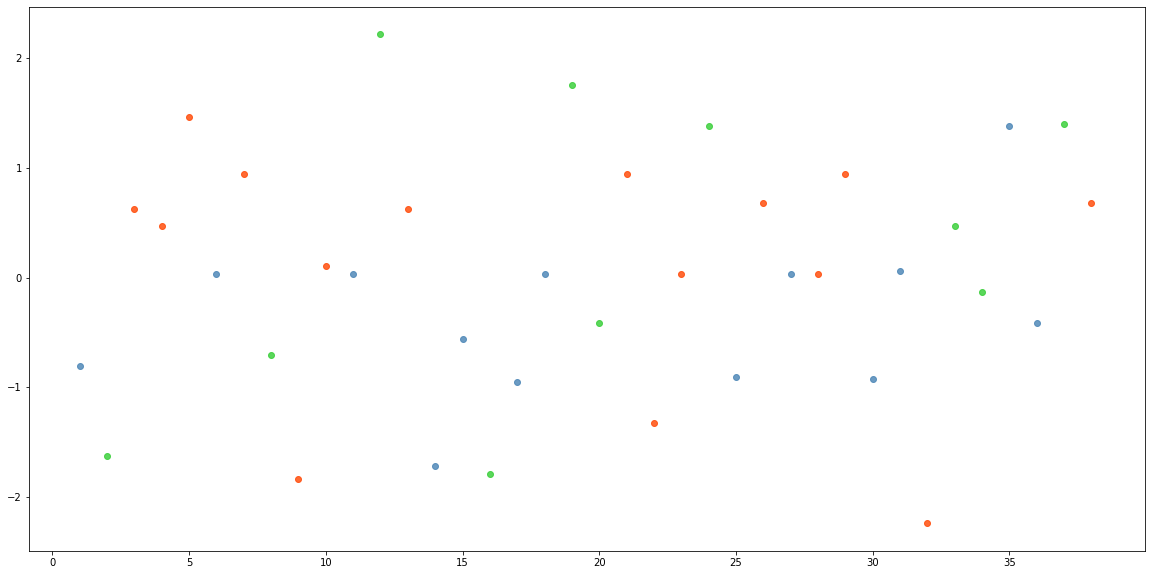

In [127]:
i = 1
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []
for a in pca(np.array(t)[:,:,0],1)[0]:
    for b in a:
        if m.iloc[i-1]['Outcome'] == 'win':
            x1.append(i)
            y1.append(b)
        elif m.iloc[i-1]['Outcome'] == 'tie':
            x2.append(i)
            y2.append(b)
        else:
            x3.append(i)
            y3.append(b)
    i += 1
plt.figure(figsize=(20,10))
plt.scatter(x1,y1,c = 'steelblue',alpha=0.8)
plt.scatter(x2,y2,c = 'limegreen',alpha=0.8)
plt.scatter(x3,y3,c = 'orangered',alpha=0.8)

In [89]:
xy_df = []
for xy in pca(struct_data,1)[0]:
    xy_df.append([xy[0,0],d[m.iloc[i]['Outcome']]])
    i += 1
# sd = pd.DataFrame(xy_df,columns=['x y','outcome'])
# sd = sd.groupby(['x y','outcome']).size().reset_index().rename(columns={0:'size'})

IndexError: single positional indexer is out-of-bounds

In [55]:
sd.corr()

,x,y,outcome,size
x,1.000000,-0.838513,-0.049187,0.113091
y,-0.838513,1.000000,0.000000,-0.039240
outcome,-0.049187,0.000000,1.000000,-0.049983
size,0.113091,-0.039240,-0.049983,1.000000


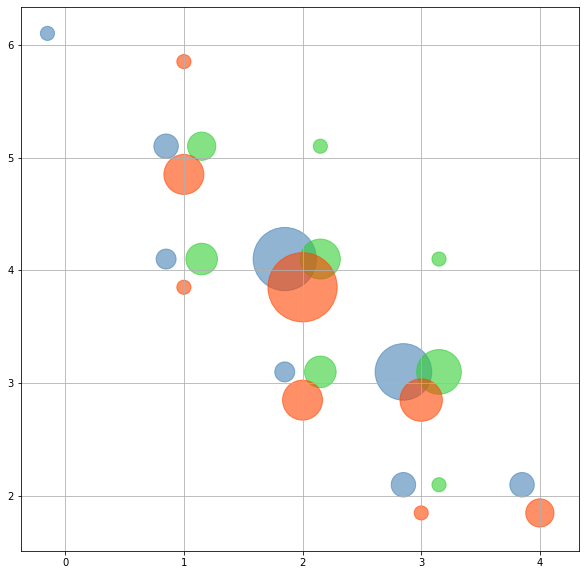

In [48]:
plt.figure(figsize=(10,10))
d = [sd.groupby('outcome').get_group('win'),sd.groupby('outcome').get_group('tie'),sd.groupby('outcome').get_group('loss')]
plt.scatter(d[0]['x']-0.15,d[0]['y']+0.1,s=d[0]['size']*200, alpha=0.6, c = 'steelblue')
plt.scatter(d[1]['x']+0.15,d[1]['y']+0.1,s=d[1]['size']*200, alpha=0.6, c = 'limegreen')
plt.scatter(d[2]['x'],d[2]['y']-0.15,s=d[2]['size']*200, alpha=0.6, c = 'orangered')
plt.grid()

In [56]:
p1 = dict([(x, 0) for x in sort(pe[(pe.MatchID == 1)]['OriginPlayerID'].unique())])
p2 = dict([(x, 0) for x in sort(pe[(pe.MatchID == 1)]['DestinationPlayerID'].unique())])
for i in range(len(pe[(pe.MatchID == 1)])):
    p1[pe['OriginPlayerID'][i]] += 1
    p2[pe['DestinationPlayerID'][i]] += 1

In [57]:
all_players = list(p1.keys())

In [58]:
print(p1)
print(p2)

{'Huskies_F1': 11, 'Huskies_F2': 38, 'Huskies_F3': 9, 'Huskies_M1': 52, 'Huskies_M2': 20, 'Huskies_M3': 45, 'Huskies_M4': 9, 'Huskies_M5': 3, 'Huskies_D1': 52, 'Huskies_D2': 36, 'Huskies_D3': 48, 'Huskies_D4': 17, 'Huskies_D5': 17, 'Huskies_G1': 12, 'Opponent1_F1': 4, 'Opponent1_F2': 17, 'Opponent1_F3': 8, 'Opponent1_F4': 3, 'Opponent1_F5': 6, 'Opponent1_M1': 32, 'Opponent1_M2': 17, 'Opponent1_M3': 27, 'Opponent1_D1': 15, 'Opponent1_D2': 22, 'Opponent1_D3': 24, 'Opponent1_D4': 8, 'Opponent1_G1': 14}
{'Huskies_F1': 19, 'Huskies_F2': 46, 'Huskies_F3': 13, 'Huskies_M1': 51, 'Huskies_M2': 15, 'Huskies_M3': 37, 'Huskies_M4': 8, 'Huskies_M5': 4, 'Huskies_D1': 44, 'Huskies_D2': 30, 'Huskies_D3': 47, 'Huskies_D4': 23, 'Huskies_D5': 20, 'Huskies_G1': 12, 'Opponent1_F1': 7, 'Opponent1_F2': 19, 'Opponent1_F3': 12, 'Opponent1_F4': 8, 'Opponent1_F5': 9, 'Opponent1_M1': 29, 'Opponent1_M2': 19, 'Opponent1_M3': 18, 'Opponent1_D1': 17, 'Opponent1_D2': 18, 'Opponent1_D3': 23, 'Opponent1_D4': 7, 'Opponen

In [59]:
shoot_lost = {}
for k in p1.keys():
    shoot_lost[k] = p2[k]-p1[k]
shoot_lost

{'Huskies_F1': 8,
 'Huskies_F2': 8,
 'Huskies_F3': 4,
 'Huskies_M1': -1,
 'Huskies_M2': -5,
 'Huskies_M3': -8,
 'Huskies_M4': -1,
 'Huskies_M5': 1,
 'Huskies_D1': -8,
 'Huskies_D2': -6,
 'Huskies_D3': -1,
 'Huskies_D4': 6,
 'Huskies_D5': 3,
 'Huskies_G1': 0,
 'Opponent1_F1': 3,
 'Opponent1_F2': 2,
 'Opponent1_F3': 4,
 'Opponent1_F4': 5,
 'Opponent1_F5': 3,
 'Opponent1_M1': -3,
 'Opponent1_M2': 2,
 'Opponent1_M3': -9,
 'Opponent1_D1': 2,
 'Opponent1_D2': -4,
 'Opponent1_D3': -1,
 'Opponent1_D4': -1,
 'Opponent1_G1': -3}

In [151]:
all_players = ['Huskies_F1',
 'Huskies_F2',
 'Huskies_F3',
 'Huskies_F4',
 'Huskies_F5',
 'Huskies_F6',
 'Huskies_M1',
 'Huskies_M2',
 'Huskies_M3',
 'Huskies_M4',
 'Huskies_M5',
 'Huskies_M6',
 'Huskies_M7',
 'Huskies_M8',
 'Huskies_M9',
 'Huskies_M10',
 'Huskies_M11',
 'Huskies_M12',
 'Huskies_M13',
 'Huskies_D1',
 'Huskies_D2',
 'Huskies_D3',
 'Huskies_D4',
 'Huskies_D5',
 'Huskies_D6',
 'Huskies_D7',
 'Huskies_D8',
 'Huskies_D9',
 'Huskies_D10',
 'Huskies_G1',
 'Opponent1_F1',
 'Opponent1_F2',
 'Opponent1_F3',
 'Opponent1_F4',
 'Opponent1_F5',
 'Opponent1_F6',
 'Opponent1_M1',
 'Opponent1_M2',
 'Opponent1_M3',
 'Opponent1_M4',
 'Opponent1_M5',
 'Opponent1_M6',
 'Opponent1_D1',
 'Opponent1_D2',
 'Opponent1_D3',
 'Opponent1_D4',
 'Opponent1_D5',
 'Opponent1_D6',
 'Opponent1_G1',
 'Opponent2_F1',
 'Opponent2_F2',
 'Opponent2_F3',
 'Opponent2_M1',
 'Opponent2_M2',
 'Opponent2_M3',
 'Opponent2_M4',
 'Opponent2_M5',
 'Opponent2_M6',
 'Opponent2_D1',
 'Opponent2_D2',
 'Opponent2_D3',
 'Opponent2_D4',
 'Opponent2_D5',
 'Opponent2_D6',
 'Opponent2_G1',
 'Opponent3_F1',
 'Opponent3_F2',
 'Opponent3_F3',
 'Opponent3_F4',
 'Opponent3_M1',
 'Opponent3_M2',
 'Opponent3_M3',
 'Opponent3_M4',
 'Opponent3_M5',
 'Opponent3_D1',
 'Opponent3_D2',
 'Opponent3_D3',
 'Opponent3_D4',
 'Opponent3_D5',
 'Opponent3_D6',
 'Opponent3_G1',
 'Opponent4_F1',
 'Opponent4_F2',
 'Opponent4_M1',
 'Opponent4_M2',
 'Opponent4_M3',
 'Opponent4_M4',
 'Opponent4_M5',
 'Opponent4_M6',
 'Opponent4_M7',
 'Opponent4_M8',
 'Opponent4_D1',
 'Opponent4_D2',
 'Opponent4_D3',
 'Opponent4_D4',
 'Opponent4_D5',
 'Opponent4_D6',
 'Opponent4_G1',
 'Opponent5_F1',
 'Opponent5_F2',
 'Opponent5_F3',
 'Opponent5_M1',
 'Opponent5_M2',
 'Opponent5_M3',
 'Opponent5_M4',
 'Opponent5_M5',
 'Opponent5_M6',
 'Opponent5_M7',
 'Opponent5_D1',
 'Opponent5_D2',
 'Opponent5_D3',
 'Opponent5_D4',
 'Opponent5_D5',
 'Opponent5_D6',
 'Opponent5_D7',
 'Opponent5_G1',
 'Opponent6_F1',
 'Opponent6_F2',
 'Opponent6_F3',
 'Opponent6_F4',
 'Opponent6_F5',
 'Opponent6_M1',
 'Opponent6_M2',
 'Opponent6_M3',
 'Opponent6_M4',
 'Opponent6_M5',
 'Opponent6_M6',
 'Opponent6_M7',
 'Opponent6_D1',
 'Opponent6_D2',
 'Opponent6_D3',
 'Opponent6_D4',
 'Opponent6_D5',
 'Opponent6_G1',
 'Opponent7_F1',
 'Opponent7_F2',
 'Opponent7_M1',
 'Opponent7_M2',
 'Opponent7_M3',
 'Opponent7_M4',
 'Opponent7_M5',
 'Opponent7_M6',
 'Opponent7_M7',
 'Opponent7_D1',
 'Opponent7_D2',
 'Opponent7_D3',
 'Opponent7_D4',
 'Opponent7_G1',
 'Opponent8_F1',
 'Opponent8_F2',
 'Opponent8_F3',
 'Opponent8_F4',
 'Opponent8_F5',
 'Opponent8_M1',
 'Opponent8_M2',
 'Opponent8_M3',
 'Opponent8_M4',
 'Opponent8_M5',
 'Opponent8_M6',
 'Opponent8_D1',
 'Opponent8_D2',
 'Opponent8_D3',
 'Opponent8_D4',
 'Opponent8_D5',
 'Opponent8_D6',
 'Opponent8_D7',
 'Opponent8_G1',
 'Opponent9_F1',
 'Opponent9_F2',
 'Opponent9_F3',
 'Opponent9_M1',
 'Opponent9_M2',
 'Opponent9_M3',
 'Opponent9_M4',
 'Opponent9_M5',
 'Opponent9_M6',
 'Opponent9_D1',
 'Opponent9_D2',
 'Opponent9_D3',
 'Opponent9_D4',
 'Opponent9_D5',
 'Opponent9_D6',
 'Opponent9_G1',
 'Opponent9_G2',
 'Opponent10_F1',
 'Opponent10_F2',
 'Opponent10_F3',
 'Opponent10_F4',
 'Opponent10_M1',
 'Opponent10_M2',
 'Opponent10_M3',
 'Opponent10_M4',
 'Opponent10_M5',
 'Opponent10_M6',
 'Opponent10_M7',
 'Opponent10_D1',
 'Opponent10_D2',
 'Opponent10_D3',
 'Opponent10_D4',
 'Opponent10_D5',
 'Opponent10_D6',
 'Opponent10_G1',
 'Opponent11_F1',
 'Opponent11_F2',
 'Opponent11_F3',
 'Opponent11_F4',
 'Opponent11_F5',
 'Opponent11_M1',
 'Opponent11_M2',
 'Opponent11_M3',
 'Opponent11_M4',
 'Opponent11_M5',
 'Opponent11_M6',
 'Opponent11_D1',
 'Opponent11_D2',
 'Opponent11_D3',
 'Opponent11_D4',
 'Opponent11_D5',
 'Opponent11_D6',
 'Opponent11_D7',
 'Opponent11_G1',
 'Opponent11_G2',
 'Opponent12_F1',
 'Opponent12_F2',
 'Opponent12_M1',
 'Opponent12_M2',
 'Opponent12_M3',
 'Opponent12_M4',
 'Opponent12_M5',
 'Opponent12_M6',
 'Opponent12_M7',
 'Opponent12_D1',
 'Opponent12_D2',
 'Opponent12_D3',
 'Opponent12_D4',
 'Opponent12_D5',
 'Opponent12_D6',
 'Opponent12_D7',
 'Opponent12_G1',
 'Opponent12_G2',
 'Opponent13_F1',
 'Opponent13_F2',
 'Opponent13_M1',
 'Opponent13_M2',
 'Opponent13_M3',
 'Opponent13_M4',
 'Opponent13_M5',
 'Opponent13_M6',
 'Opponent13_M7',
 'Opponent13_M8',
 'Opponent13_D1',
 'Opponent13_D2',
 'Opponent13_D3',
 'Opponent13_D4',
 'Opponent13_D5',
 'Opponent13_D6',
 'Opponent13_G1',
 'Opponent13_G2',
 'Opponent14_F1',
 'Opponent14_F2',
 'Opponent14_F3',
 'Opponent14_F4',
 'Opponent14_M1',
 'Opponent14_M2',
 'Opponent14_M3',
 'Opponent14_M4',
 'Opponent14_M5',
 'Opponent14_M6',
 'Opponent14_D1',
 'Opponent14_D2',
 'Opponent14_D3',
 'Opponent14_D4',
 'Opponent14_D5',
 'Opponent14_D6',
 'Opponent14_D7',
 'Opponent14_G1',
 'Opponent14_G2',
 'Opponent15_F1',
 'Opponent15_F2',
 'Opponent15_F3',
 'Opponent15_F4',
 'Opponent15_M1',
 'Opponent15_M2',
 'Opponent15_M3',
 'Opponent15_M4',
 'Opponent15_M5',
 'Opponent15_M6',
 'Opponent15_M7',
 'Opponent15_M8',
 'Opponent15_D1',
 'Opponent15_D2',
 'Opponent15_D3',
 'Opponent15_D4',
 'Opponent15_D5',
 'Opponent15_D6',
 'Opponent15_G1',
 'Opponent16_F1',
 'Opponent16_F2',
 'Opponent16_F3',
 'Opponent16_F4',
 'Opponent16_F5',
 'Opponent16_F6',
 'Opponent16_M1',
 'Opponent16_M2',
 'Opponent16_M3',
 'Opponent16_M4',
 'Opponent16_D1',
 'Opponent16_D2',
 'Opponent16_D3',
 'Opponent16_D4',
 'Opponent16_D5',
 'Opponent16_G1',
 'Opponent16_G2',
 'Opponent17_F1',
 'Opponent17_F2',
 'Opponent17_F3',
 'Opponent17_F4',
 'Opponent17_M1',
 'Opponent17_M2',
 'Opponent17_M3',
 'Opponent17_M4',
 'Opponent17_M5',
 'Opponent17_M6',
 'Opponent17_M7',
 'Opponent17_M8',
 'Opponent17_D1',
 'Opponent17_D2',
 'Opponent17_D3',
 'Opponent17_D4',
 'Opponent17_D5',
 'Opponent17_G1',
 'Opponent17_G2',
 'Opponent18_F1',
 'Opponent18_F2',
 'Opponent18_F3',
 'Opponent18_M1',
 'Opponent18_M2',
 'Opponent18_M3',
 'Opponent18_M4',
 'Opponent18_M5',
 'Opponent18_M6',
 'Opponent18_M7',
 'Opponent18_M8',
 'Opponent18_D1',
 'Opponent18_D2',
 'Opponent18_D3',
 'Opponent18_D4',
 'Opponent18_G1',
 'Opponent19_F1',
 'Opponent19_F2',
 'Opponent19_F3',
 'Opponent19_M1',
 'Opponent19_M2',
 'Opponent19_M3',
 'Opponent19_M4',
 'Opponent19_M5',
 'Opponent19_M6',
 'Opponent19_D1',
 'Opponent19_D2',
 'Opponent19_D3',
 'Opponent19_D4',
 'Opponent19_D5',
 'Opponent19_G1']

In [149]:
def passing_count(matches,time):
    if time is not None:
        spe = pe[(pe.MatchID.isin(matches))&(pe.EventTime.isin(time))]
    else:
        spe = pe[(pe.MatchID.isin(matches))]
    se1 = spe[(spe.TeamID=='Huskies')]
    t1 = set(np.append(se1['OriginPlayerID'].unique(),se1['DestinationPlayerID'].unique()))
    played_p1 = list(dict(sorted([(all_players.index(x),x) for x in t1])).values())
    se2 = spe[(spe.TeamID!='Huskies')]
    t2 = set(np.append(se2['OriginPlayerID'].unique(),se2['DestinationPlayerID'].unique()))
    played_p2 = list(dict(sorted([(all_players.index(x),x) for x in t2])).values())
    m1 = np.zeros(shape=[len(played_p1)]*2)
    m2 = np.zeros(shape=[len(played_p2)]*2)
    for i in range(len(spe)):
        if spe['TeamID'].iloc[i] == 'Huskies':
            m1[played_p1.index(spe['OriginPlayerID'].iloc[i]),
                played_p1.index(spe['DestinationPlayerID'].iloc[i])] += 1
        else:
            m2[played_p2.index(spe['OriginPlayerID'].iloc[i]),
                played_p2.index(spe['DestinationPlayerID'].iloc[i])] += 1
    return m1,played_p1,m2,played_p2

In [124]:
dual = []
th = 3
for i in range(len(m1)):
    for j in range(i+1,len(m1)):
        if m1[i,j] >=th and m1[j,i] >= th:
            dual.append((m1[i,j]+m1[j,i],p1[i],p1[j]))

In [125]:
sorted(dual)

[(6.0, 'Huskies_F2', 'Huskies_D1'),
 (7.0, 'Huskies_M2', 'Huskies_D4'),
 (8.0, 'Huskies_F1', 'Huskies_F2'),
 (10.0, 'Huskies_F2', 'Huskies_M3'),
 (10.0, 'Huskies_M3', 'Huskies_D1'),
 (11.0, 'Huskies_M2', 'Huskies_M3'),
 (12.0, 'Huskies_F2', 'Huskies_D5'),
 (13.0, 'Huskies_D3', 'Huskies_D4'),
 (14.0, 'Huskies_D1', 'Huskies_D3'),
 (14.0, 'Huskies_M3', 'Huskies_D3'),
 (17.0, 'Huskies_M1', 'Huskies_M3'),
 (24.0, 'Huskies_D2', 'Huskies_D3'),
 (24.0, 'Huskies_F2', 'Huskies_M1'),
 (24.0, 'Huskies_M1', 'Huskies_D1'),
 (25.0, 'Huskies_D1', 'Huskies_D2')]

In [144]:
def get_all_cases(bases):
    def rotate(m):
        p1 = np.matrix([[0, 1, 0.],
         [0., 0., 1],
         [1, 0, 0.]])
        p2 = np.matrix([[0, 0, 1],
         [1, 0., 0],
         [0, 1, 0.]])
        return p1*m*p2
    def filp(m):
        p3 = np.matrix([[1, 0, 0.],
         [0., 0., 1.],
         [0., 1, 0.]])
        p4 = p3
        return p3*m*p4
    def _get_cases(c,m):
        r = rotate(m)
        f = filp(m)
        r_flag = True
        f_flag = True
        for t in c:
            if (t==r).all():
                r_flag = False
        if r_flag:
            c.append(r)
            _get_cases(c,r)
        for t in c:
            if (t==f).all():
                f_flag = False
        if f_flag:
            c.append(f)
            _get_cases(c,f)
    all_cases = []
    for b in bases:
        c = [b]
        _get_cases(c,b)
        all_cases.append(c)
    return all_cases

In [145]:
c1 = np.matrix([[0., 1., 1],
         [0., 0., 0],
         [0., 0, 0.]])
c2 = np.matrix([[0., 1., 0.],
         [0., 0., 1.],
         [0., 0, 0.]])
c3 = np.matrix([[0., 1., 0.],
         [1, 0., 1.],
         [0., 0, 0.]])
c4 = np.matrix([[0., 1., 0.],
         [0., 0., 0],
         [0., 1, 0.]])
c5 = np.matrix([[0., 1., 0.],
         [0., 0., 0],
         [1, 1, 0.]])
c6 = np.matrix([[0., 1., 1],
         [0., 0., 0],
         [1, 1, 0.]])
c7 = np.matrix([[0., 0, 1],
         [0., 0., 1.],
         [1, 0, 0.]])
c8 = np.matrix([[0., 0, 1],
         [0., 0., 1.],
         [1, 1, 0.]])
c9 = np.matrix([[0., 1., 0.],
         [0., 0., 1.],
         [1, 0, 0.]])
c10 = np.matrix([[0., 1., 0.],
         [0., 0., 1.],
         [1, 1, 0.]])
c11 = np.matrix([[0., 1., 1],
         [0., 0., 1.],
         [0, 1, 0.]])
c12 = np.matrix([[0., 1., 1],
         [0., 0., 1.],
         [1, 1, 0.]])
c13 = np.matrix([[0., 1., 1],
         [1, 0., 1.],
         [1, 1, 0.]])
all_modes = get_all_cases([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13])

In [155]:
def get_modes(match,huskies,time):
    if huskies:
        m1,p1,_,_ = passing_count(match,time)
    else:
        _,_,m1,p1 = passing_count(match,time)
    tri = []
    th = 3
    for i in range(len(m1)):
        for j in range(i+1,len(m1)):
            for k in range(j+1,len(m1)):
                m = np.zeros(shape=(3,3))
                ij = m1[i,j]
                ik = m1[i,k]
                ji = m1[j,i]
                jk = m1[j,k]
                ki = m1[k,i]
                kj = m1[k,j]
                if ij>th:
                    m[0,1] = 1
                if ik>th:
                    m[0,2] = 1
                if ji>th:
                    m[1,0] = 1
                if jk>th:
                    m[1,2] = 1
                if ki>th:
                    m[2,0] = 1
                if kj>th:
                    m[2,1] = 1
                if np.sum(m)>1:
                    tri.append((m,ij+ik+ji+jk+ki+kj,p1[i],p1[j],p1[k]))
    classified_modes = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[]}
    for mode in tri:
        for i in range(len(all_modes)):
            for case in all_modes[i]:
                if (mode[0]==case).all():
                    classified_modes[i+1].append(mode)
    return classified_modes

In [427]:
m1_modes = get_modes([1],True,None)

In [423]:
get_modes([1],False,None)

{1: [(array([[0., 0., 0.],
          [0., 0., 0.],
          [1., 1., 0.]]),
   11.0,
   'Opponent1_F1',
   'Opponent1_D1',
   'Opponent1_D2'),
  (array([[0., 1., 1.],
          [0., 0., 0.],
          [0., 0., 0.]]),
   12.0,
   'Opponent1_M1',
   'Opponent1_M2',
   'Opponent1_D1')],
 2: [(array([[0., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.]]),
   16.0,
   'Opponent1_F2',
   'Opponent1_M2',
   'Opponent1_M3'),
  (array([[0., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.]]),
   16.0,
   'Opponent1_F2',
   'Opponent1_D1',
   'Opponent1_D2'),
  (array([[0., 0., 1.],
          [1., 0., 0.],
          [0., 0., 0.]]),
   16.0,
   'Opponent1_M1',
   'Opponent1_M3',
   'Opponent1_D1')],
 3: [(array([[0., 0., 0.],
          [0., 0., 1.],
          [1., 1., 0.]]),
   15.0,
   'Opponent1_F1',
   'Opponent1_M1',
   'Opponent1_D2'),
  (array([[0., 1., 1.],
          [0., 0., 0.],
          [1., 0., 0.]]),
   16.0,
   'Opponent1_M1',
   'Opponent1_M2',
   'Opponent1_D2'),
  

In [342]:
def unify_pos(row):
    row[-4:] = np.floor(row[-4:]/10)
    return row
unified_pe = pe.apply(func=unify_pos,axis=1)

In [377]:
grouped_pe = unified_pe[(unified_pe.MatchID==1)].groupby(["OriginPlayerID","DestinationPlayerID"])
team_pe = pe[(pe.MatchID==1)]

D:\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


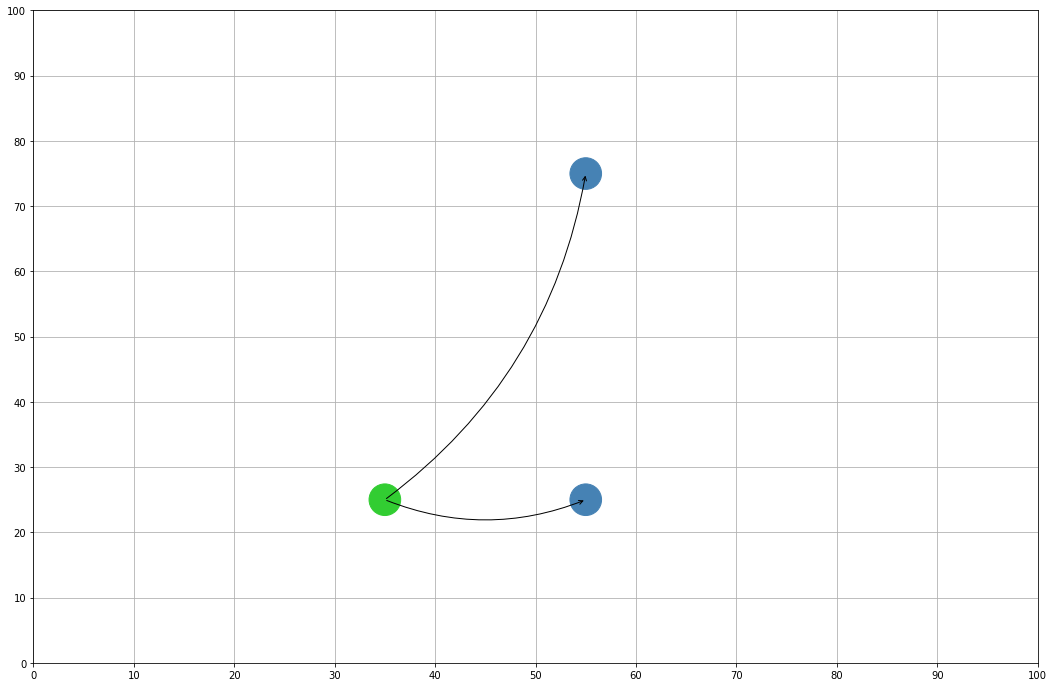

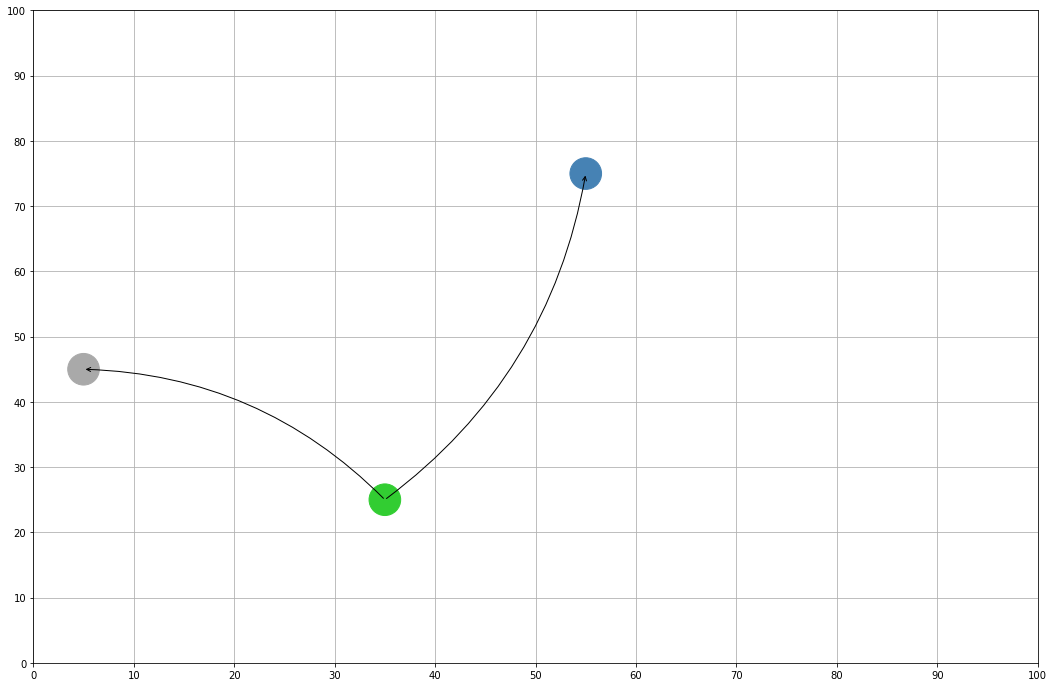

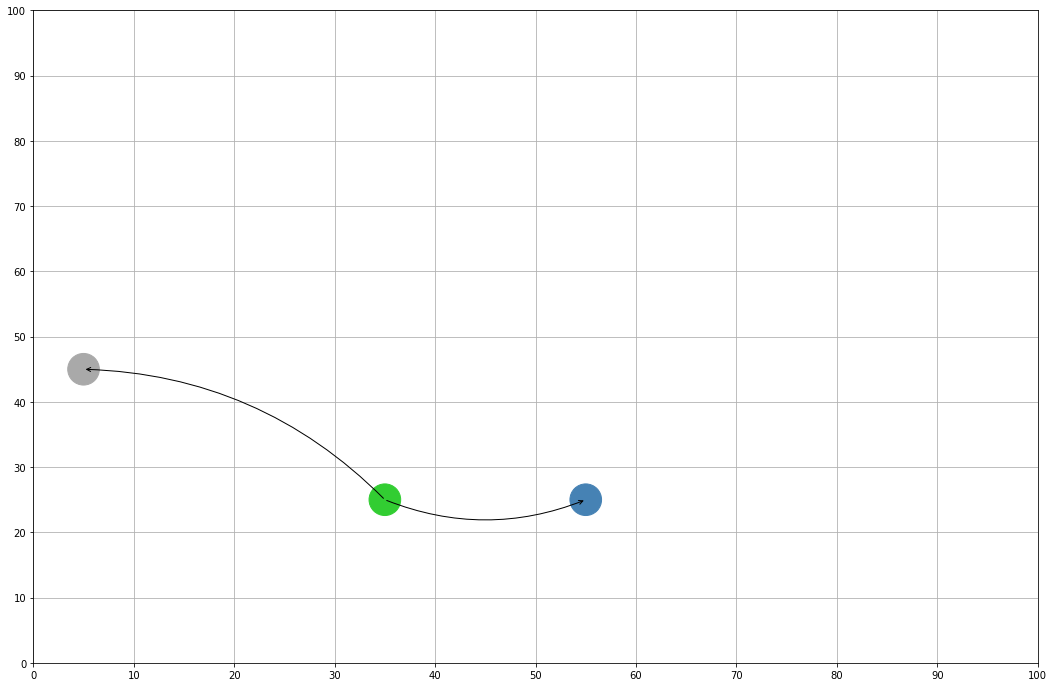

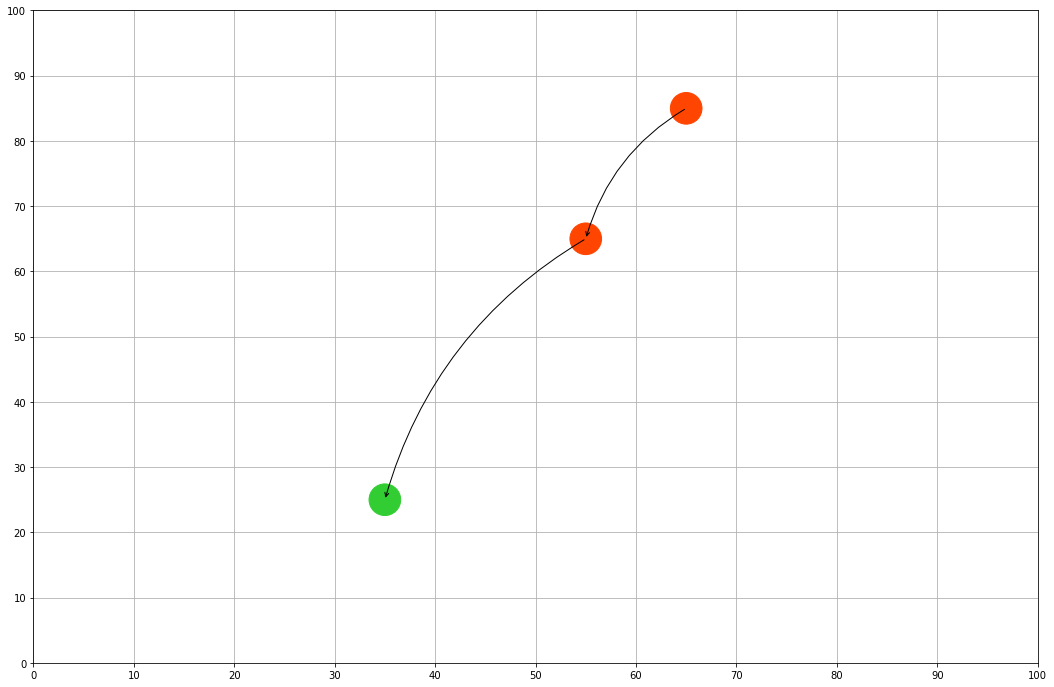

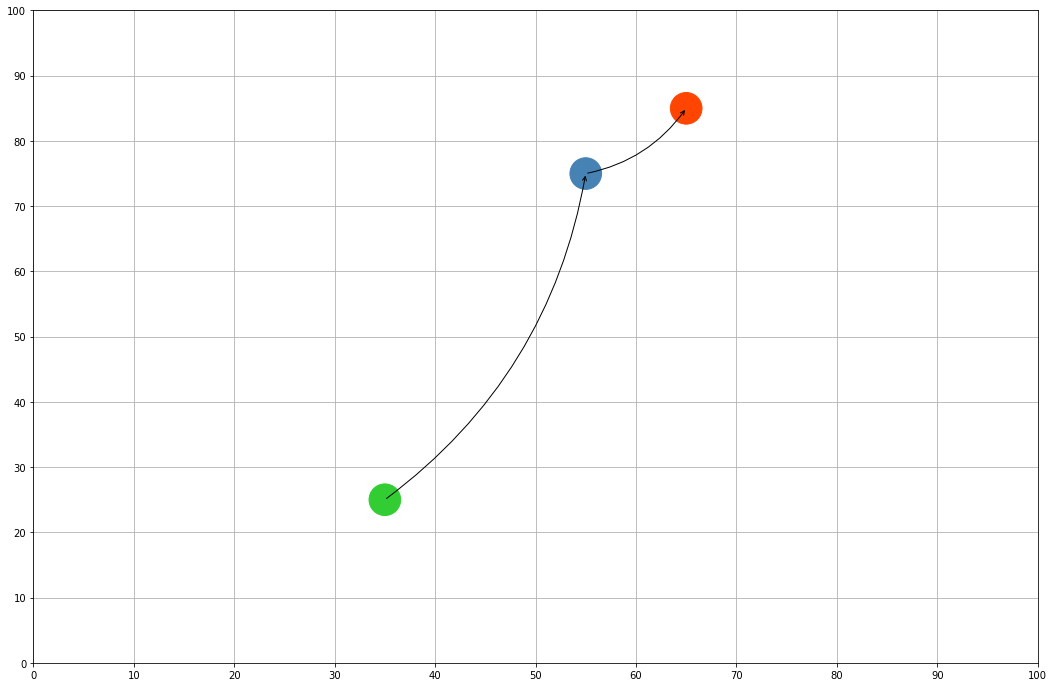

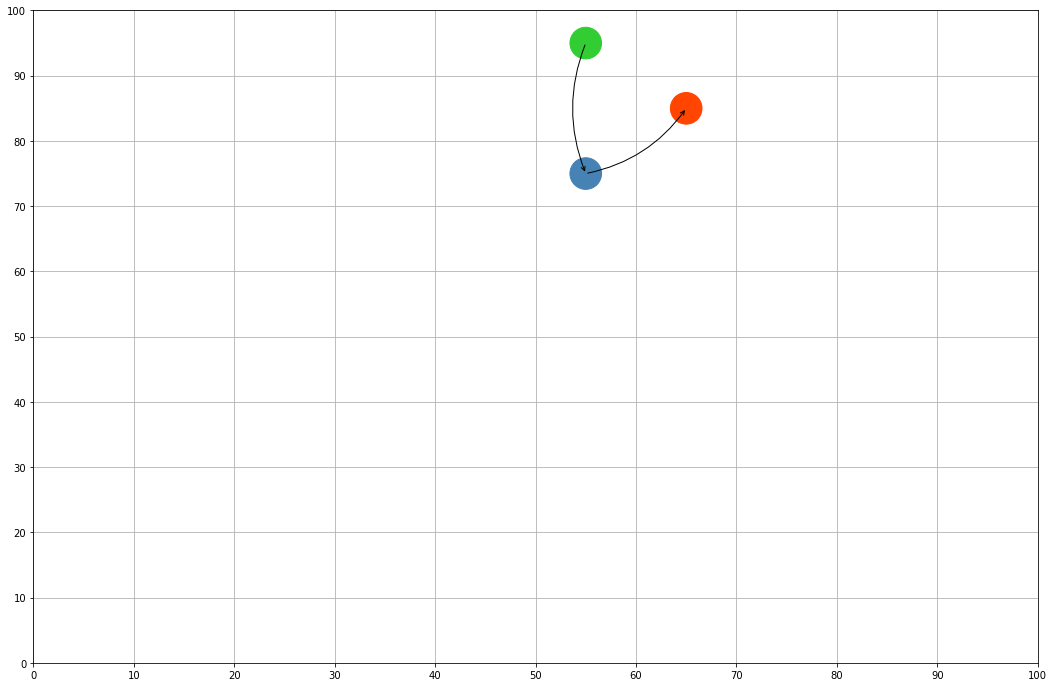

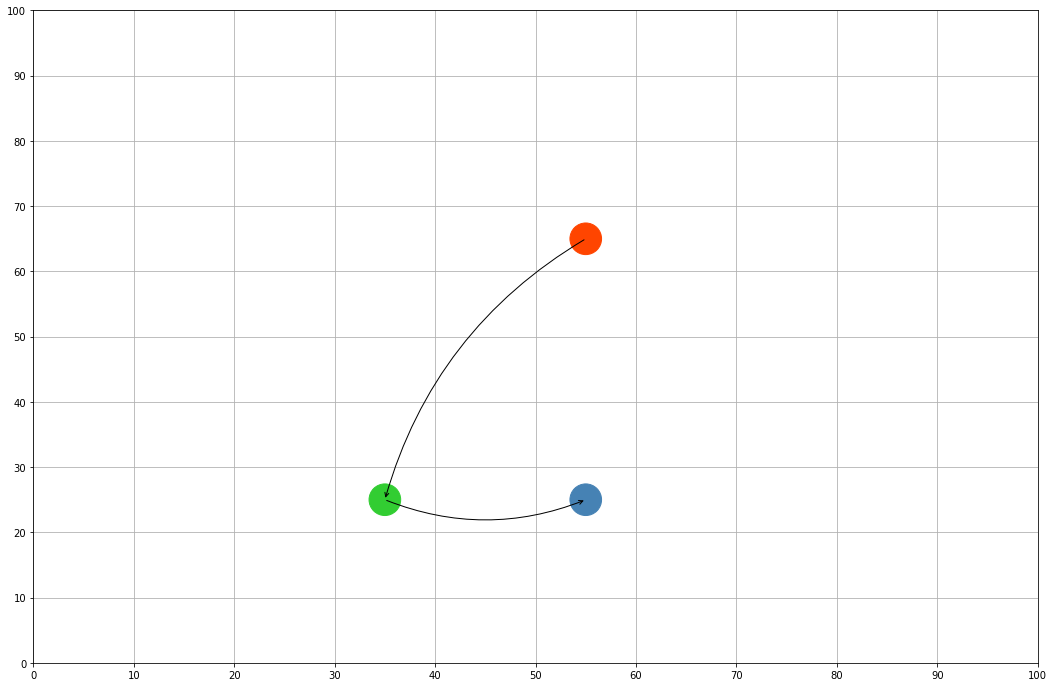

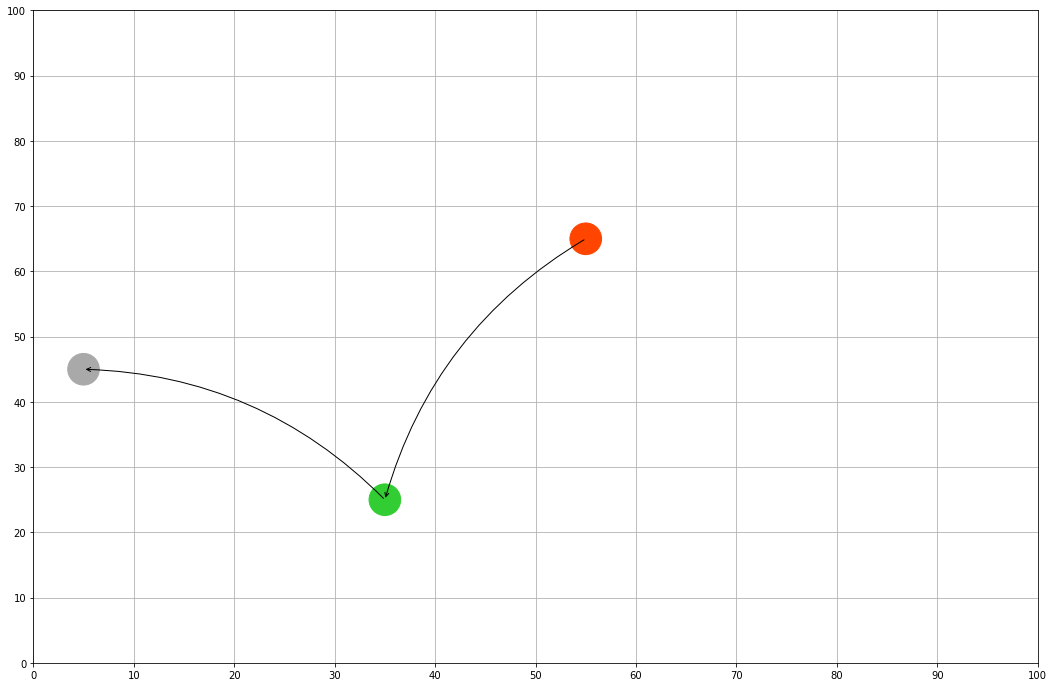

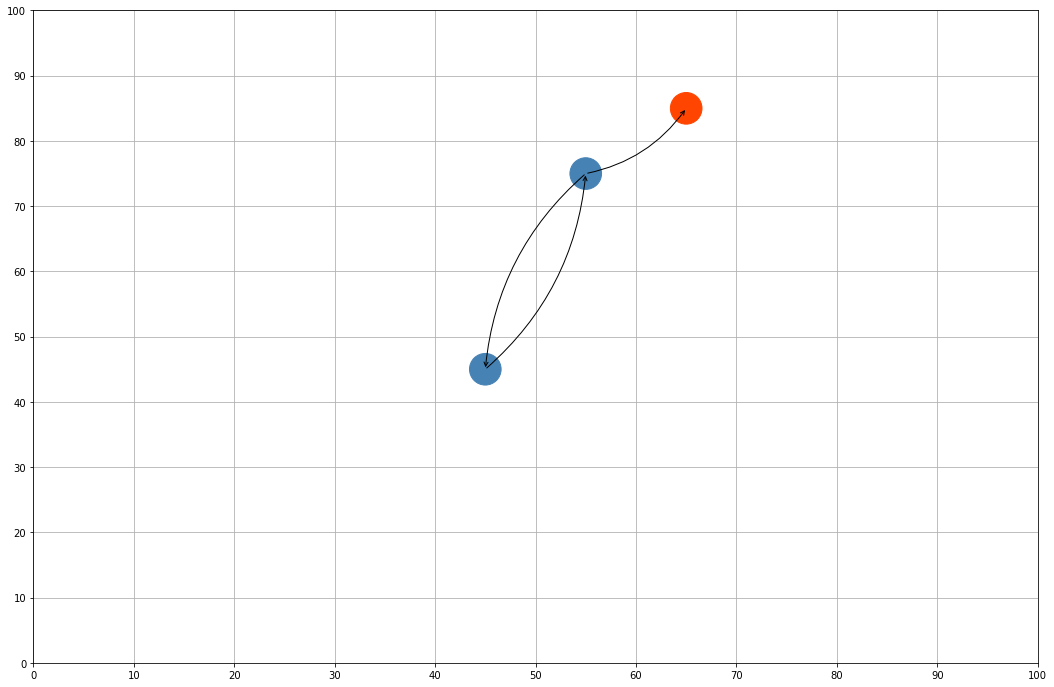

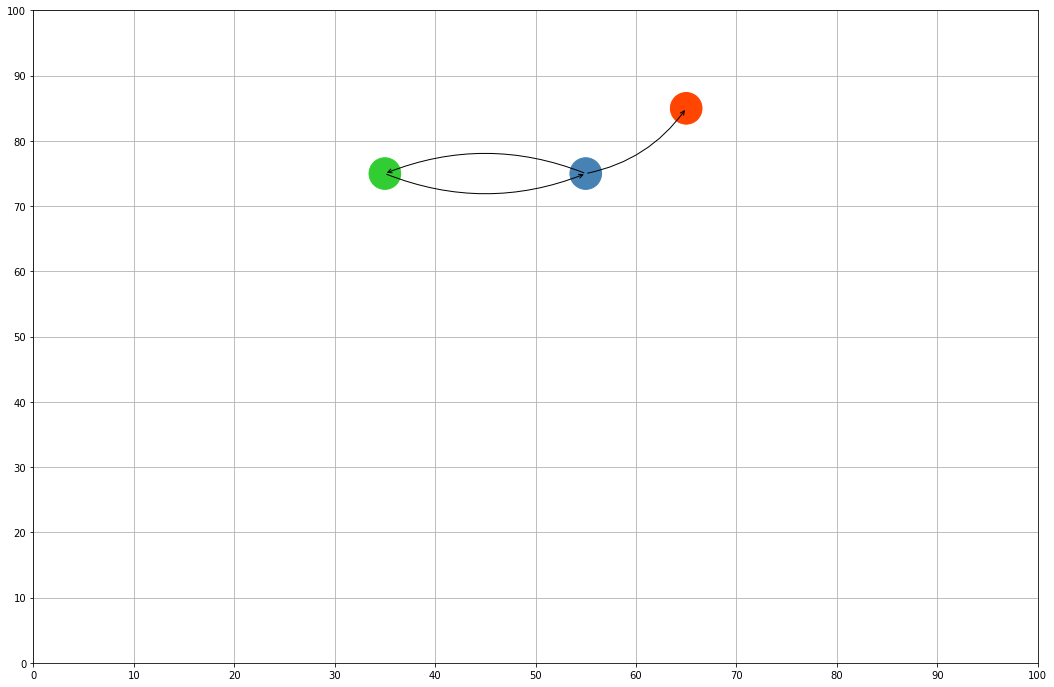

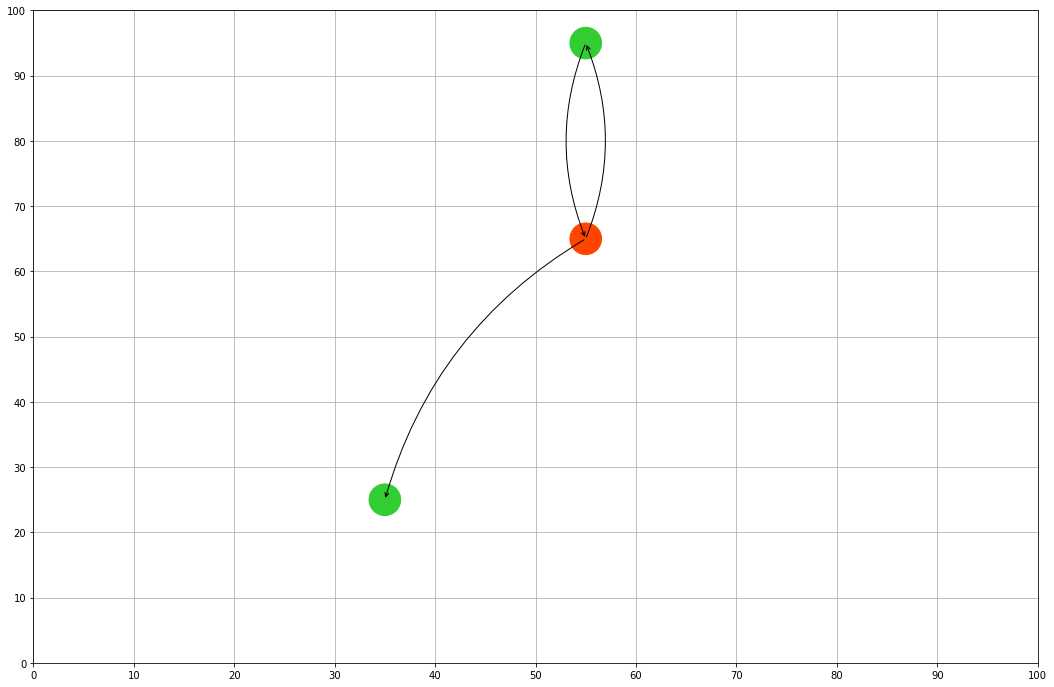

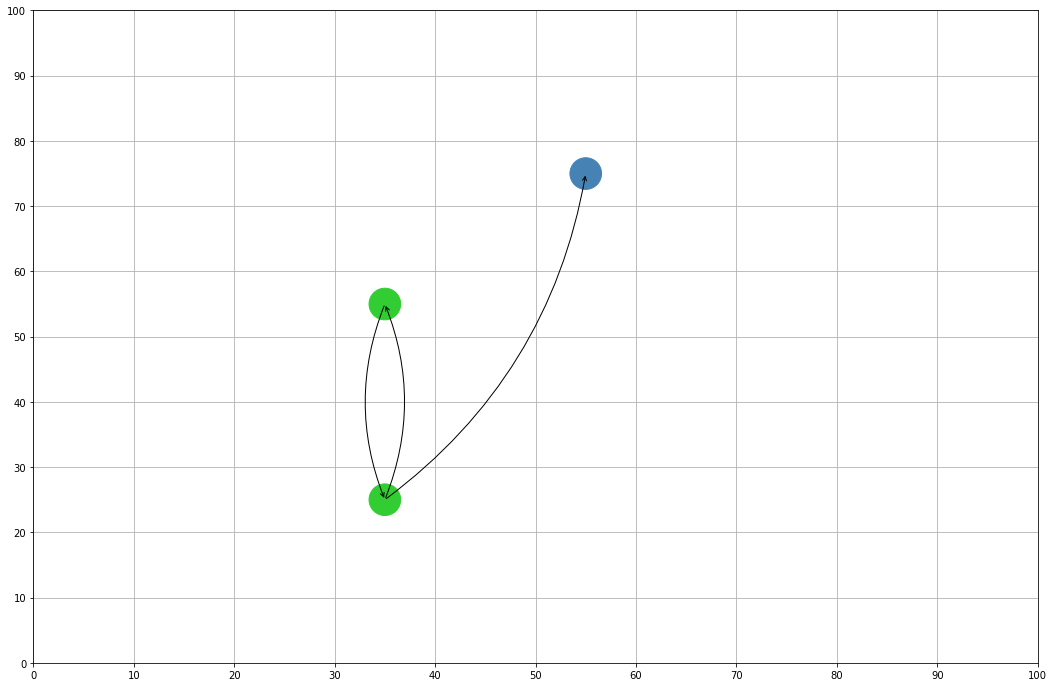

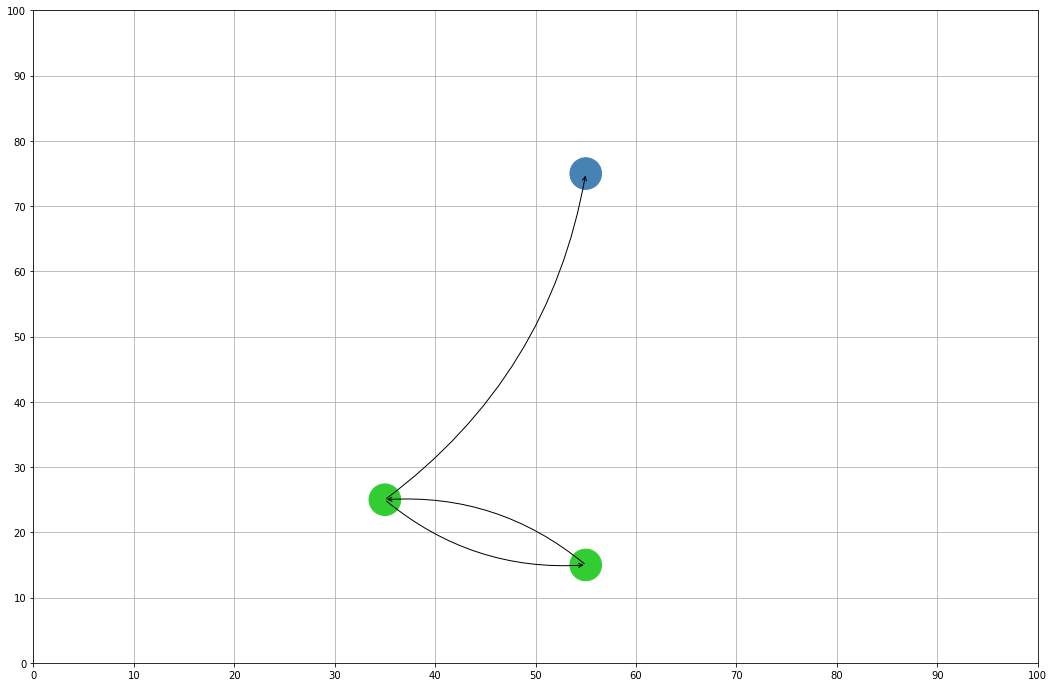

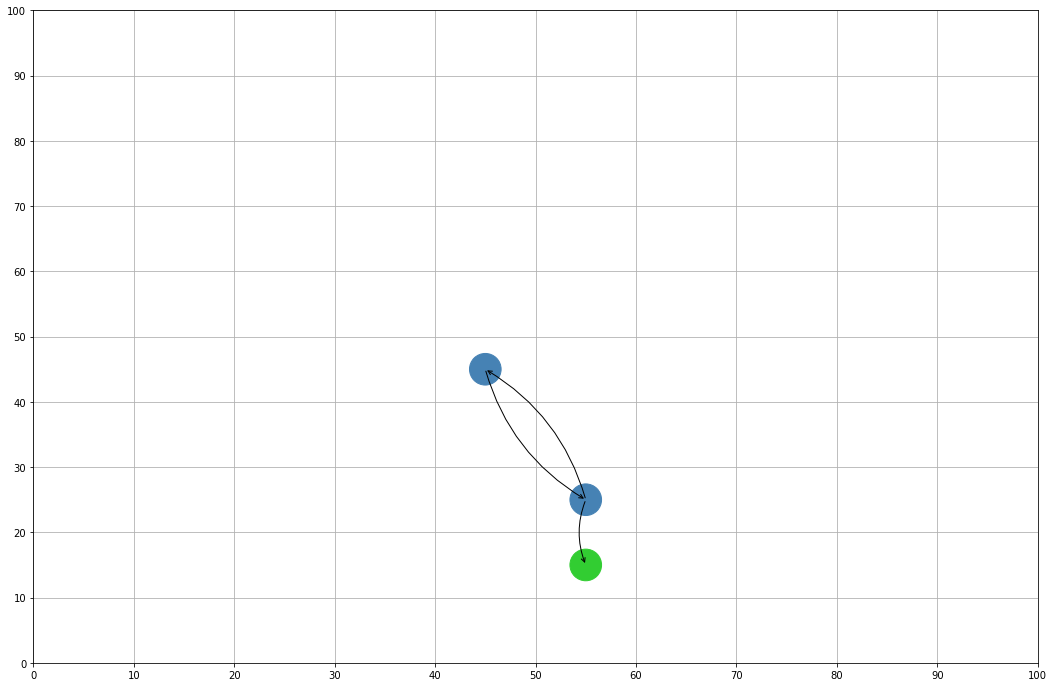

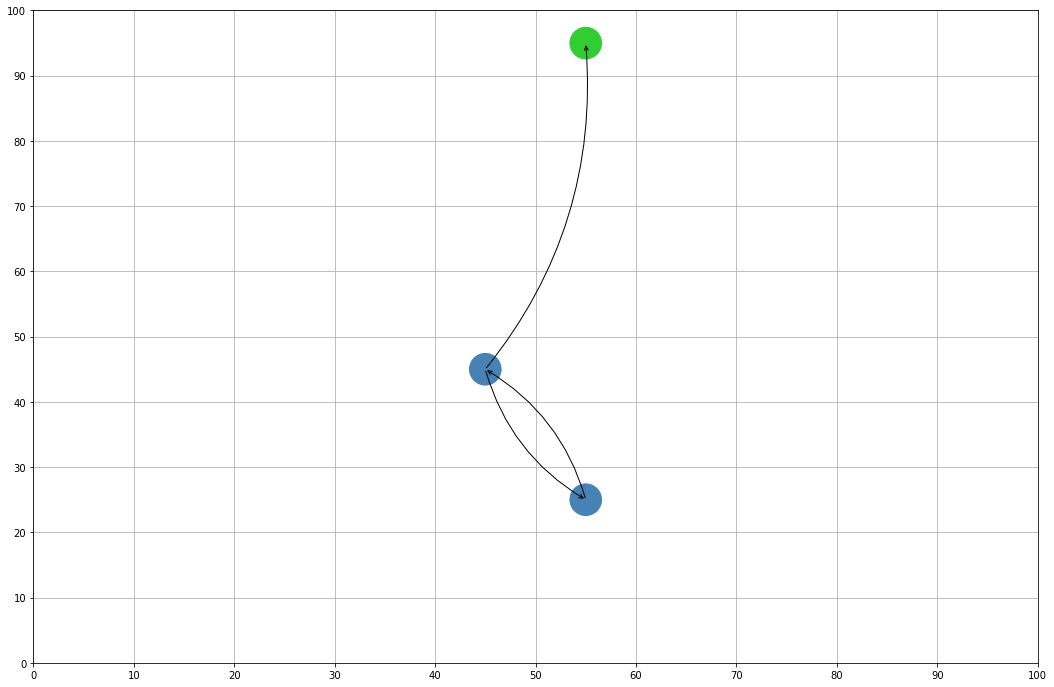

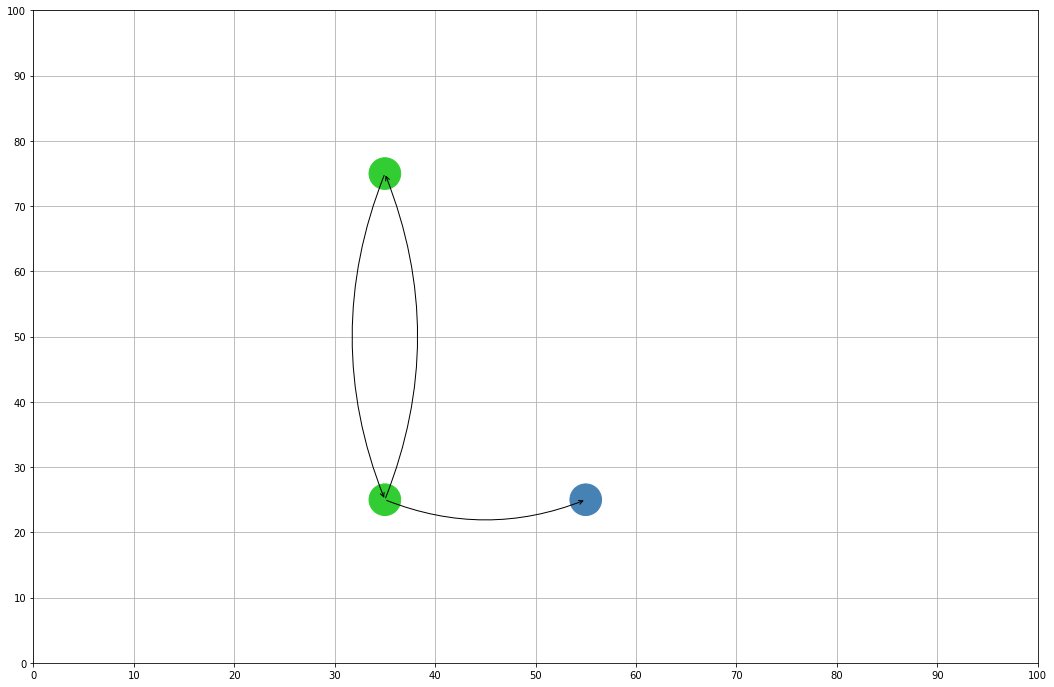

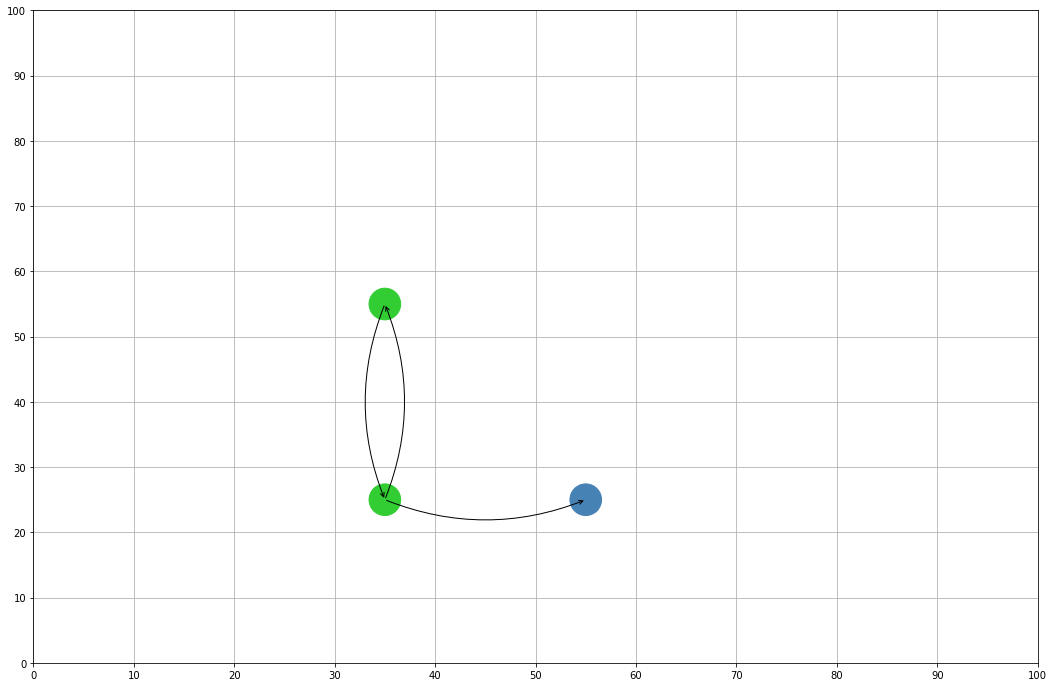

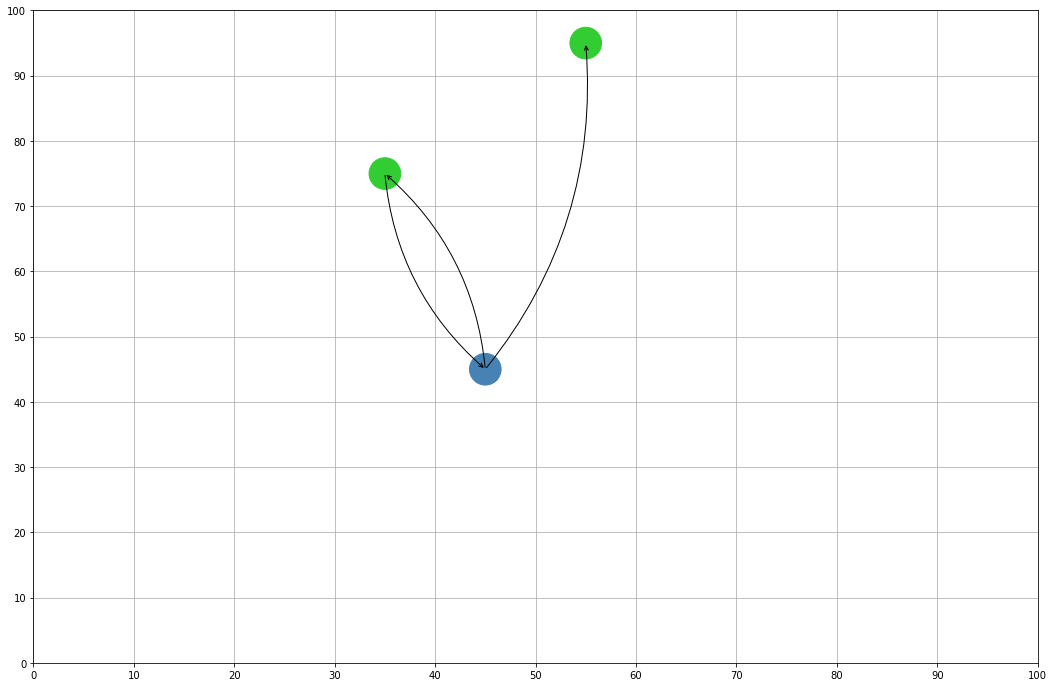

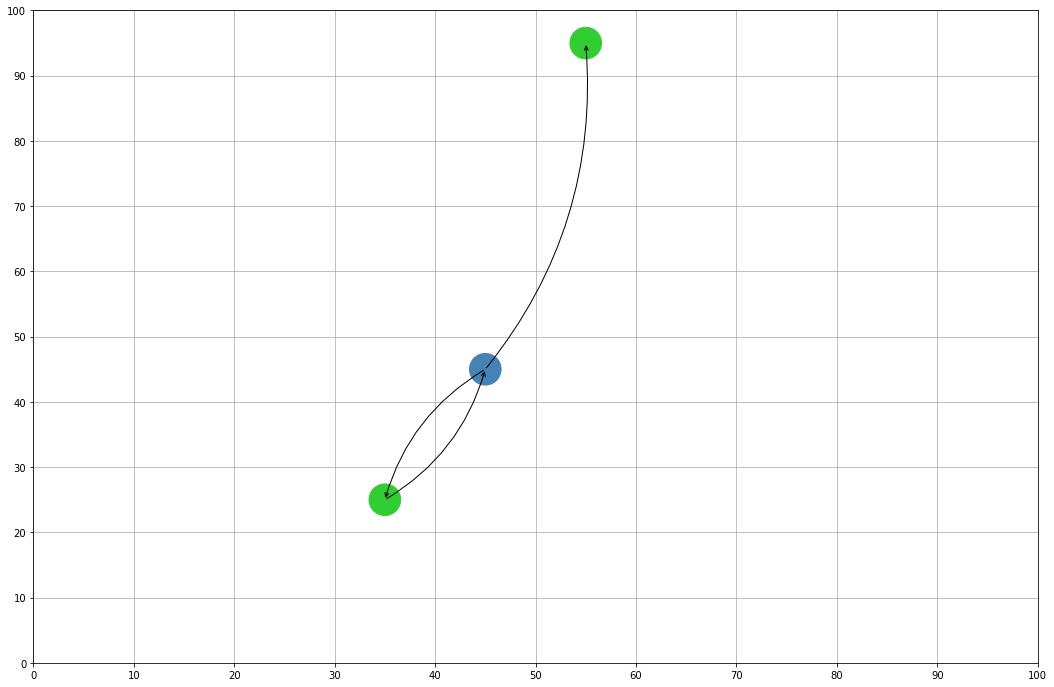

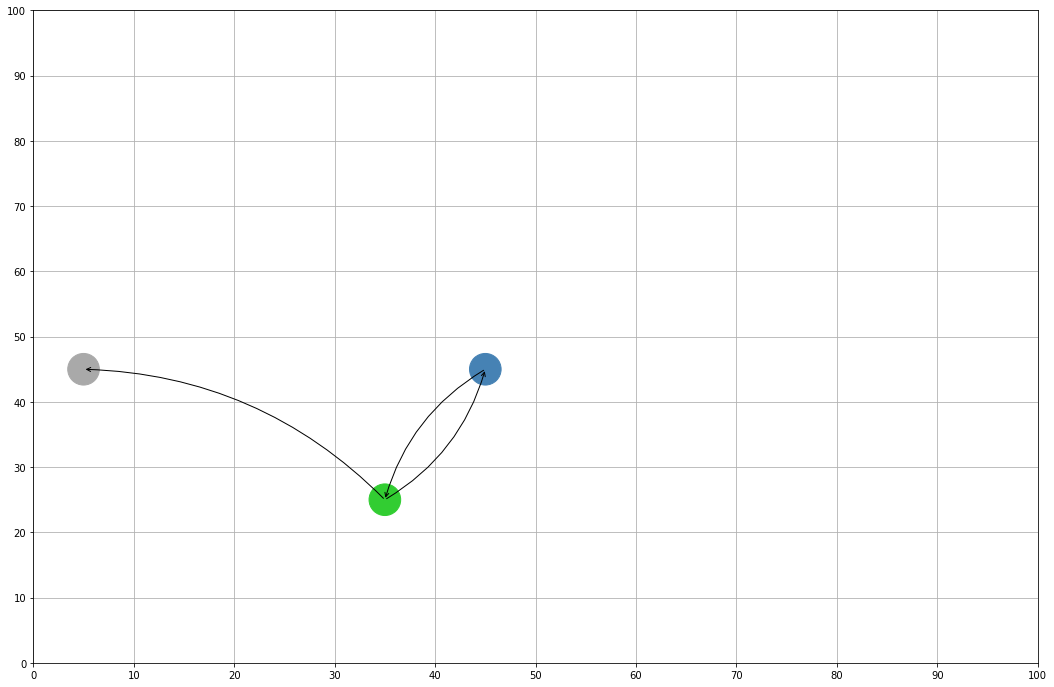

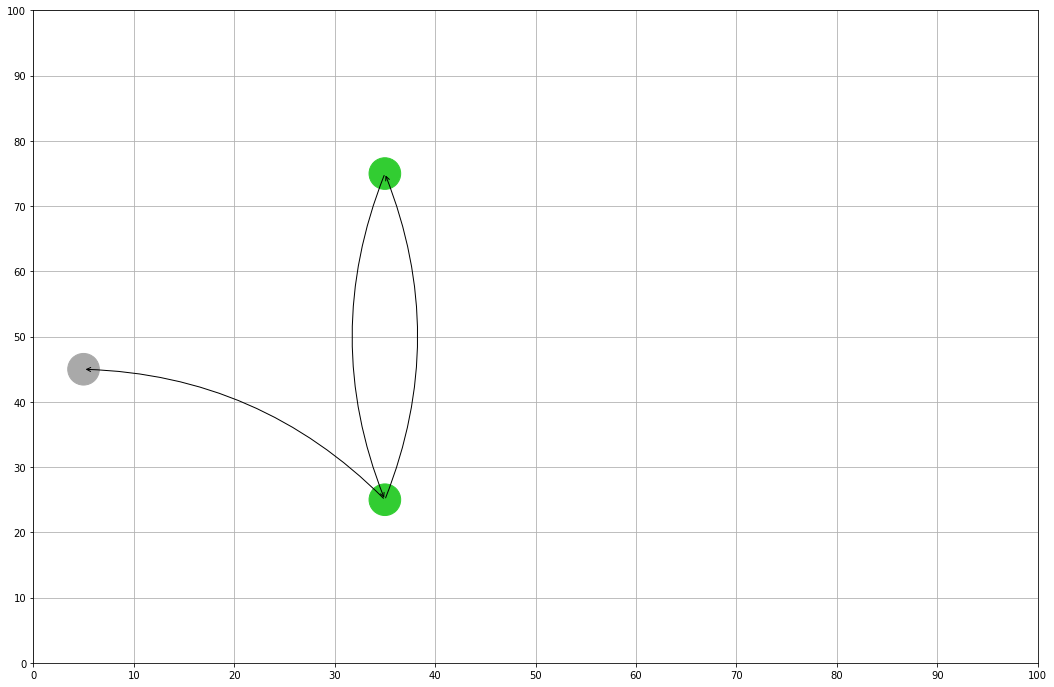

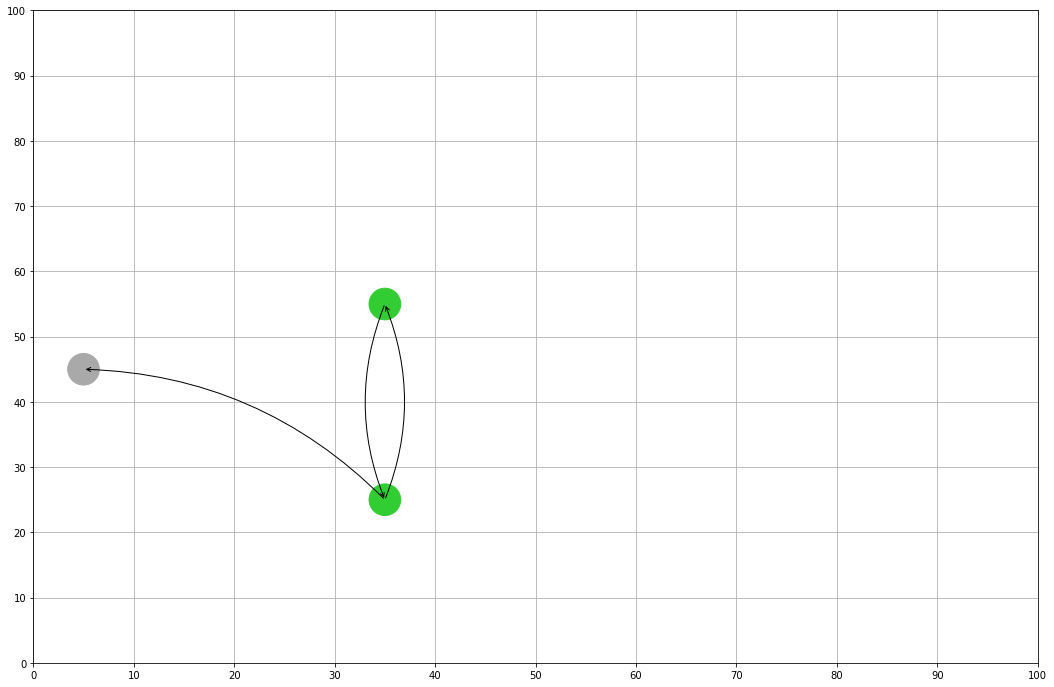

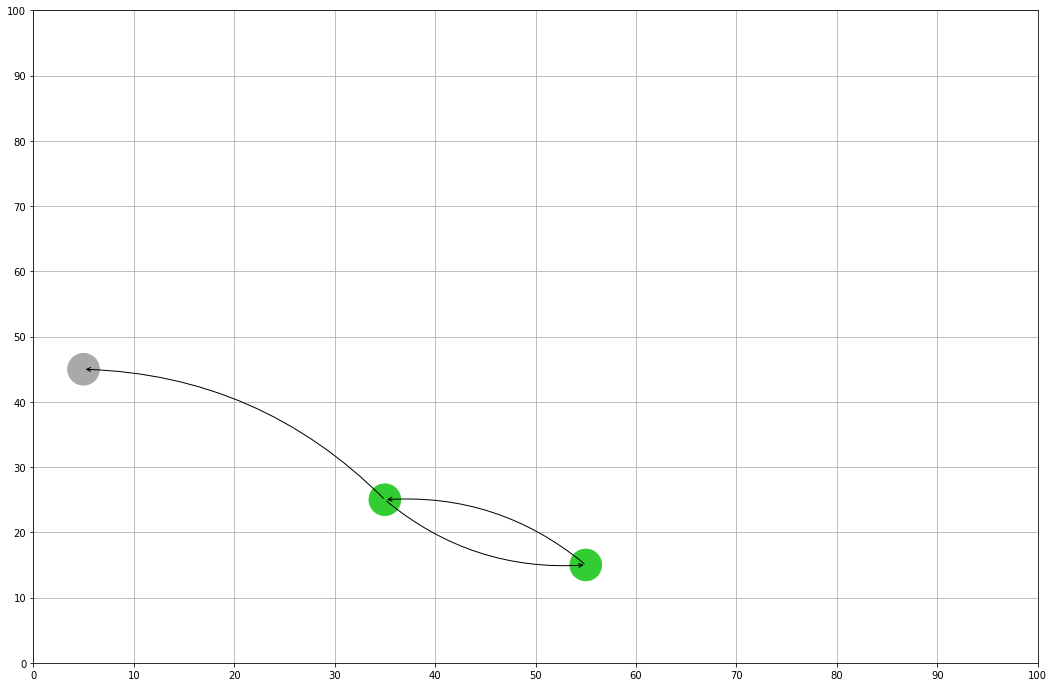

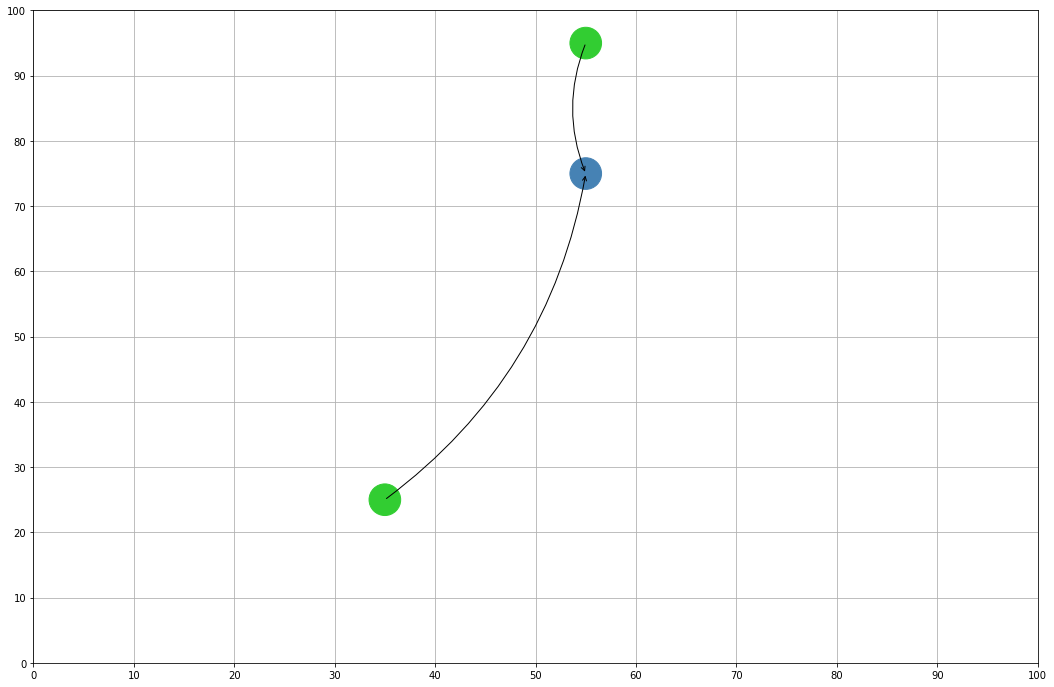

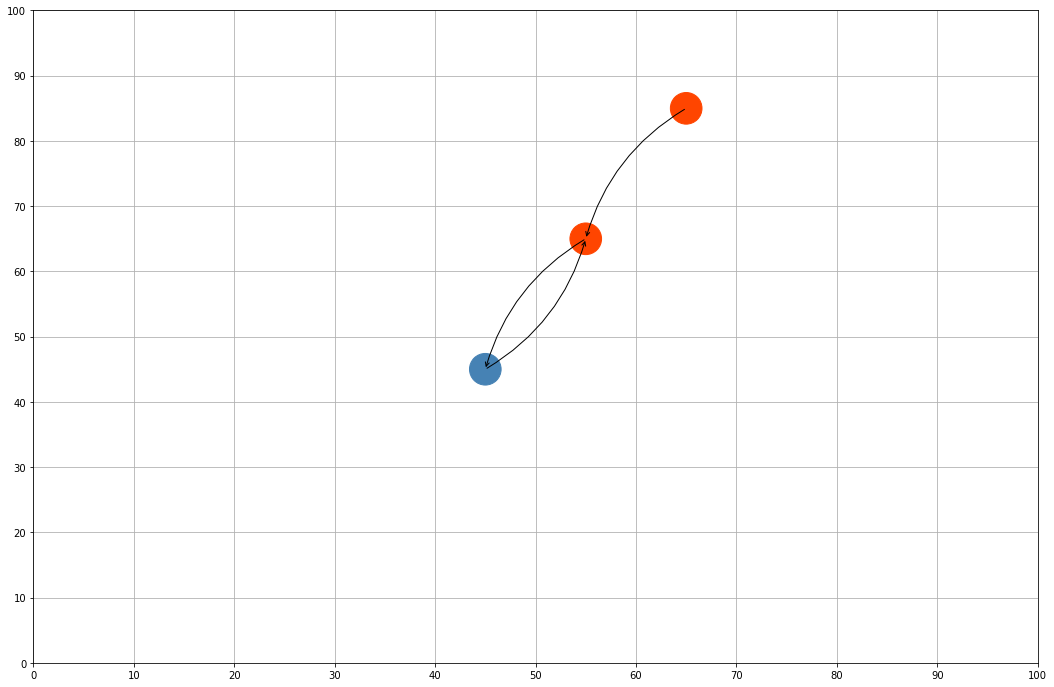

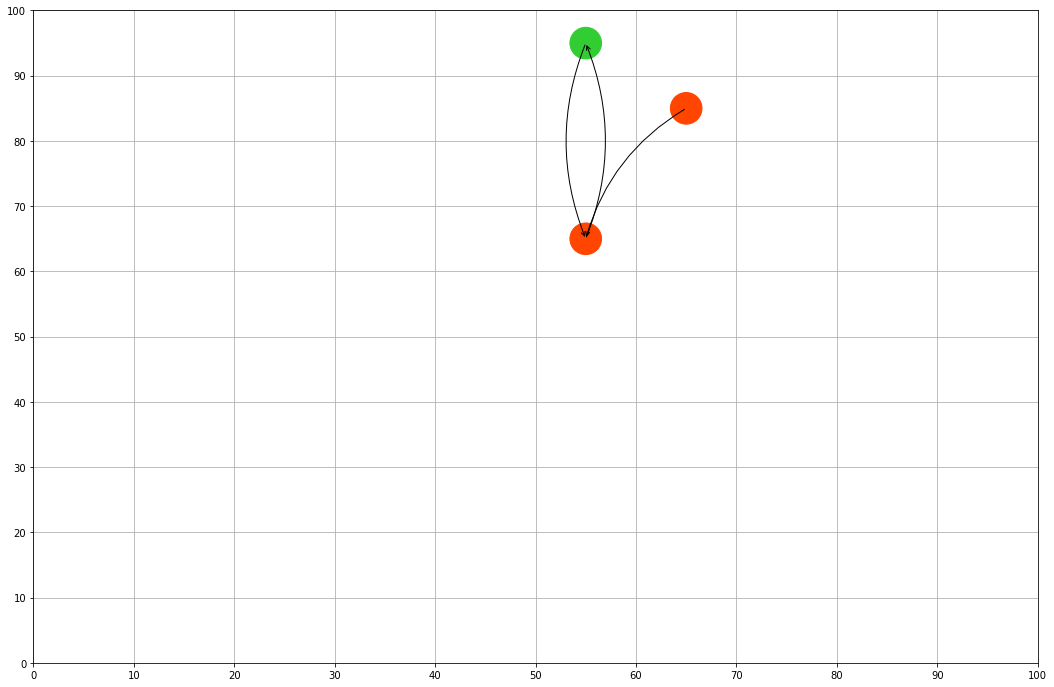

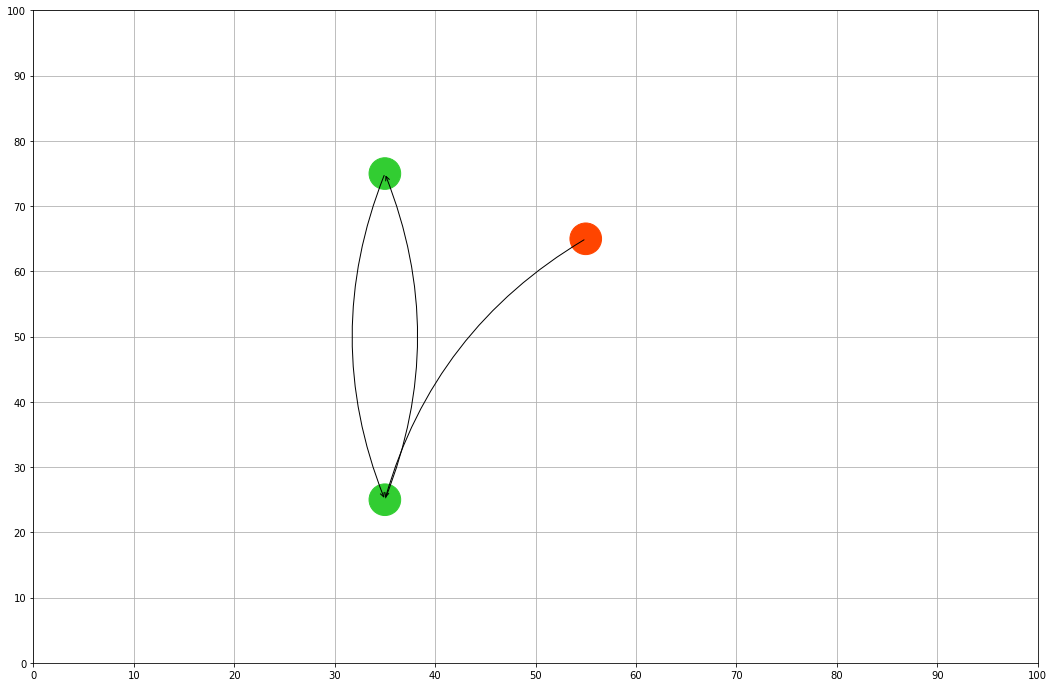

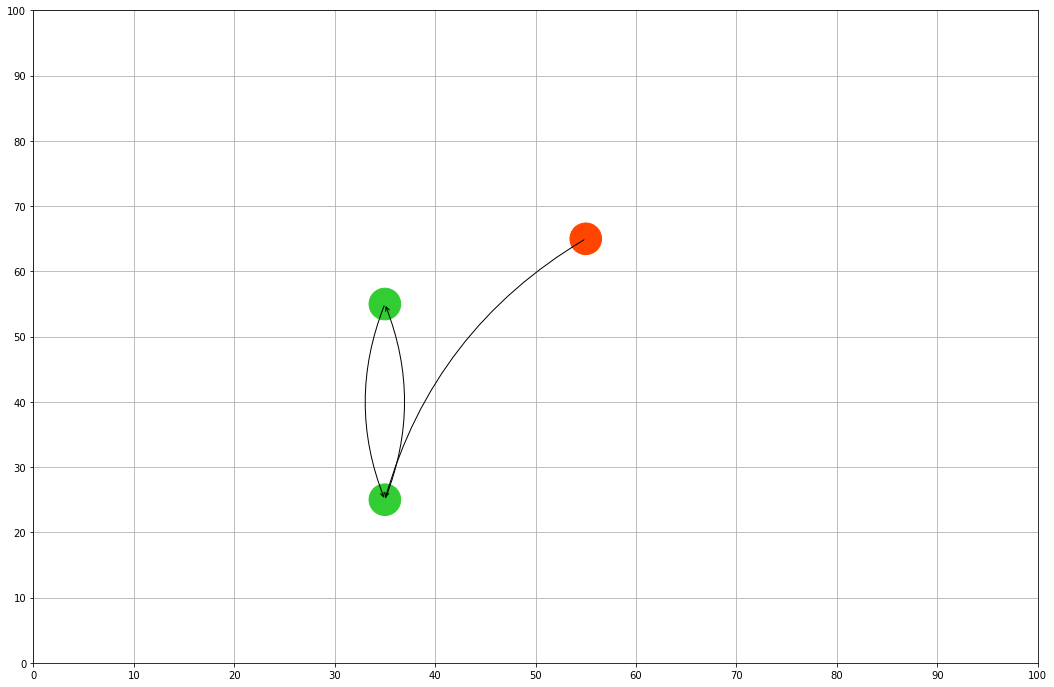

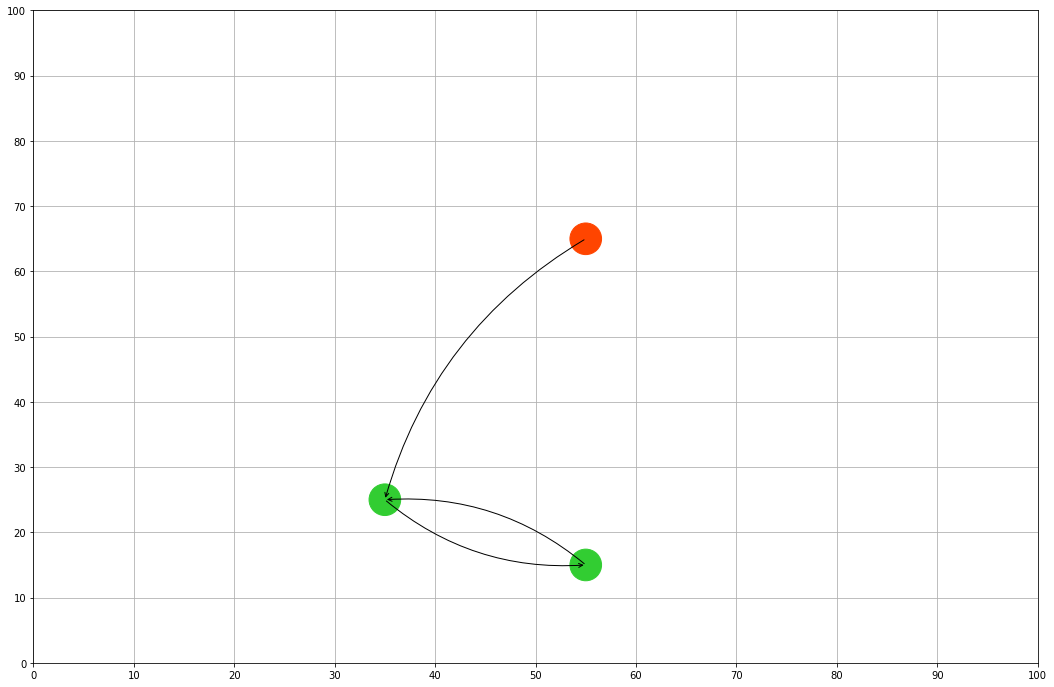

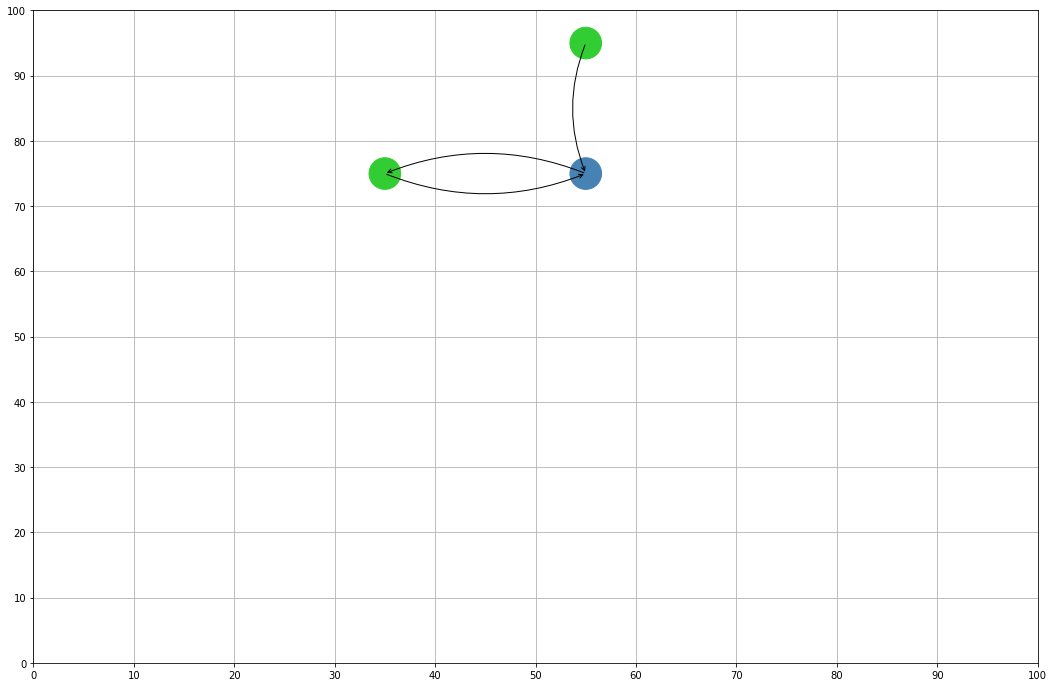

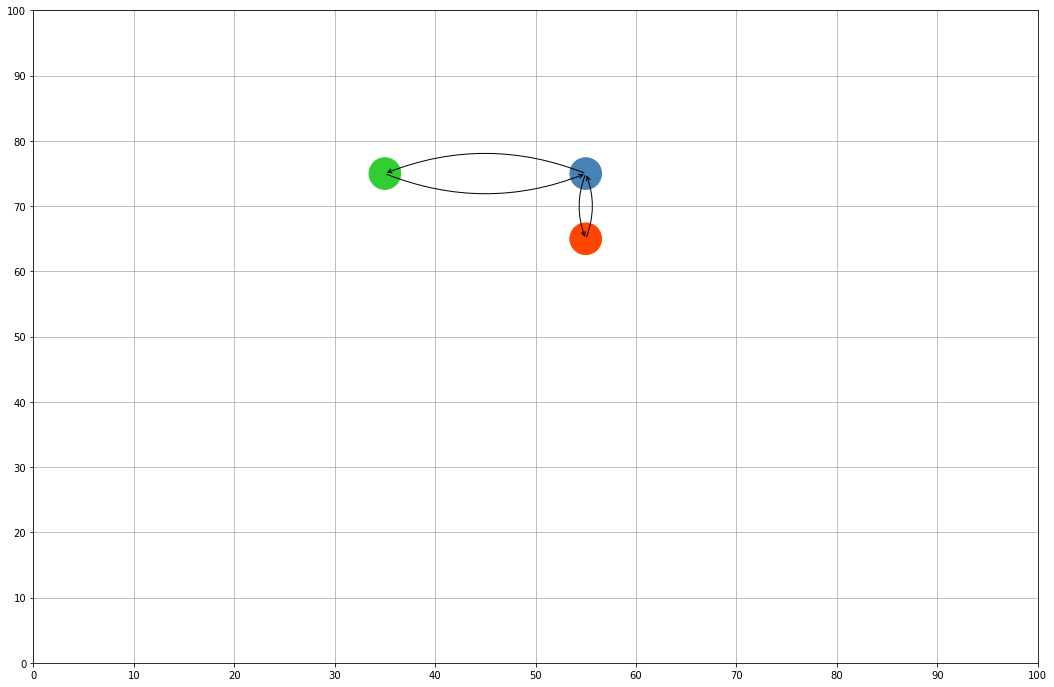

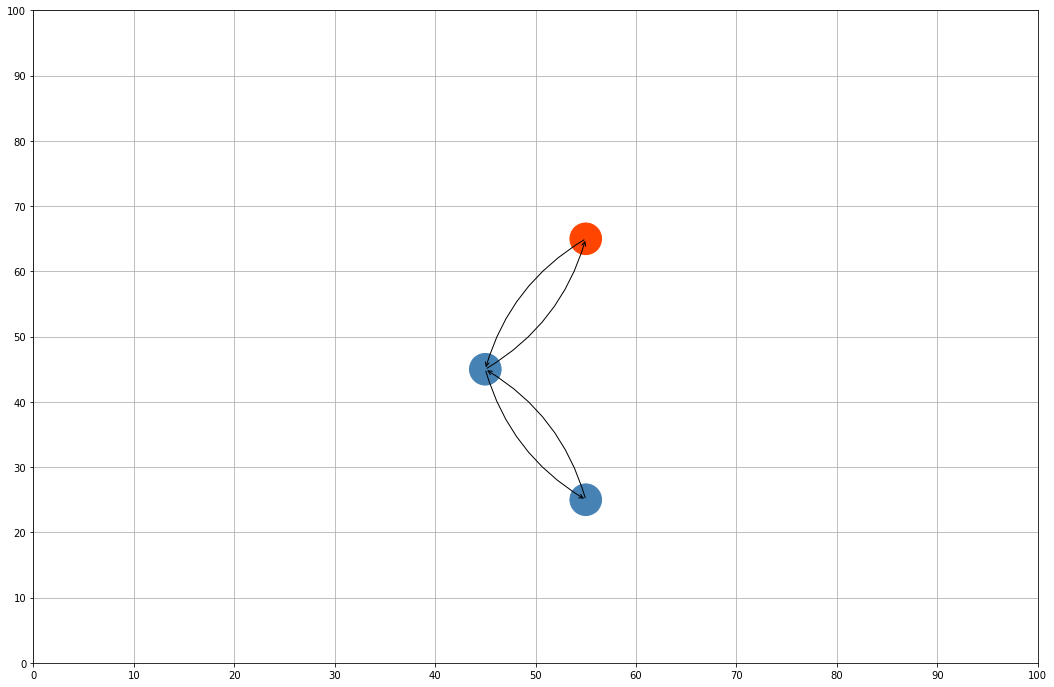

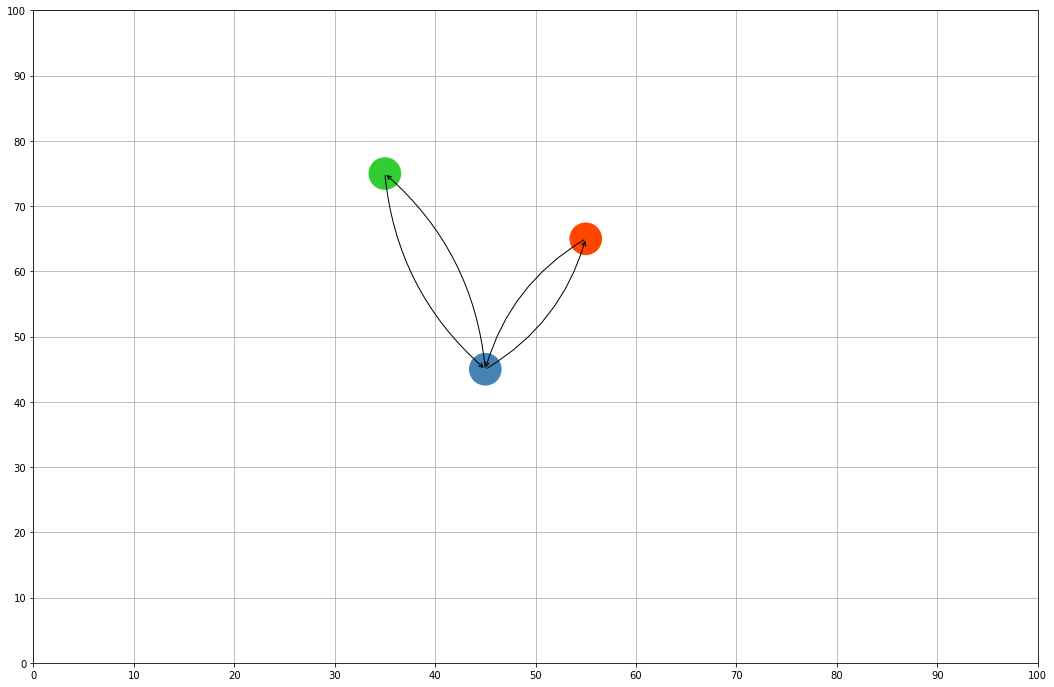

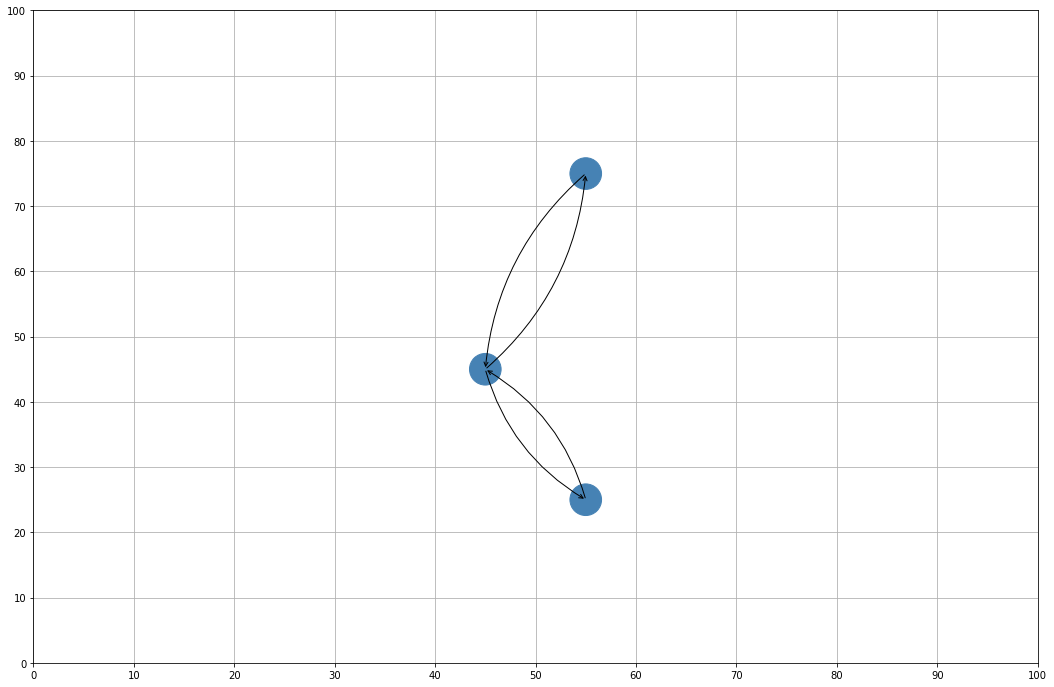

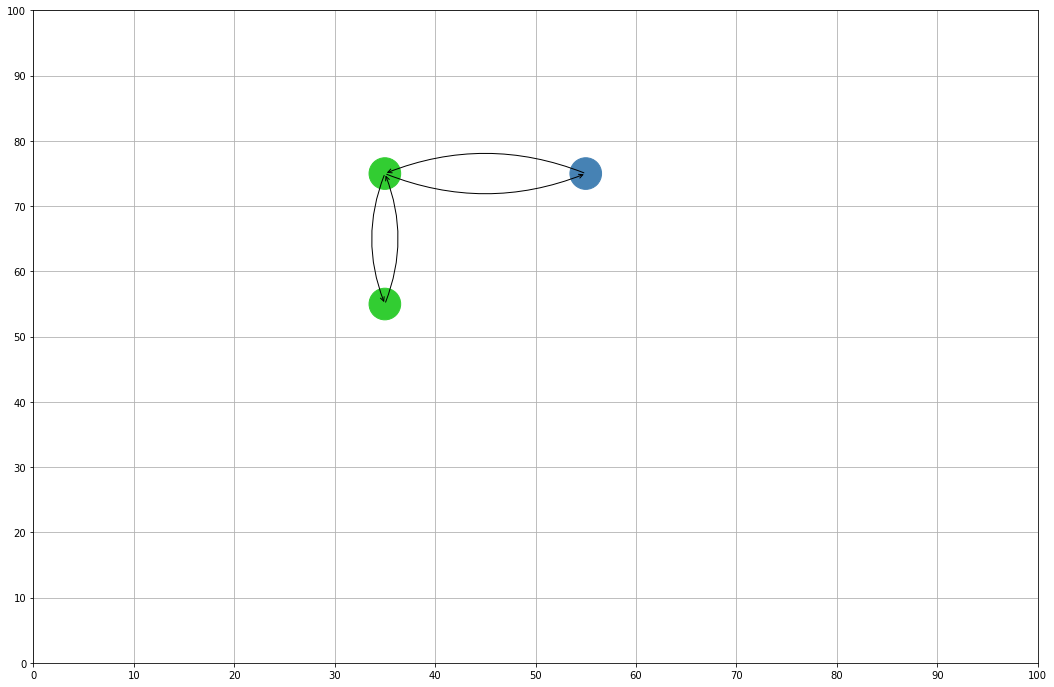

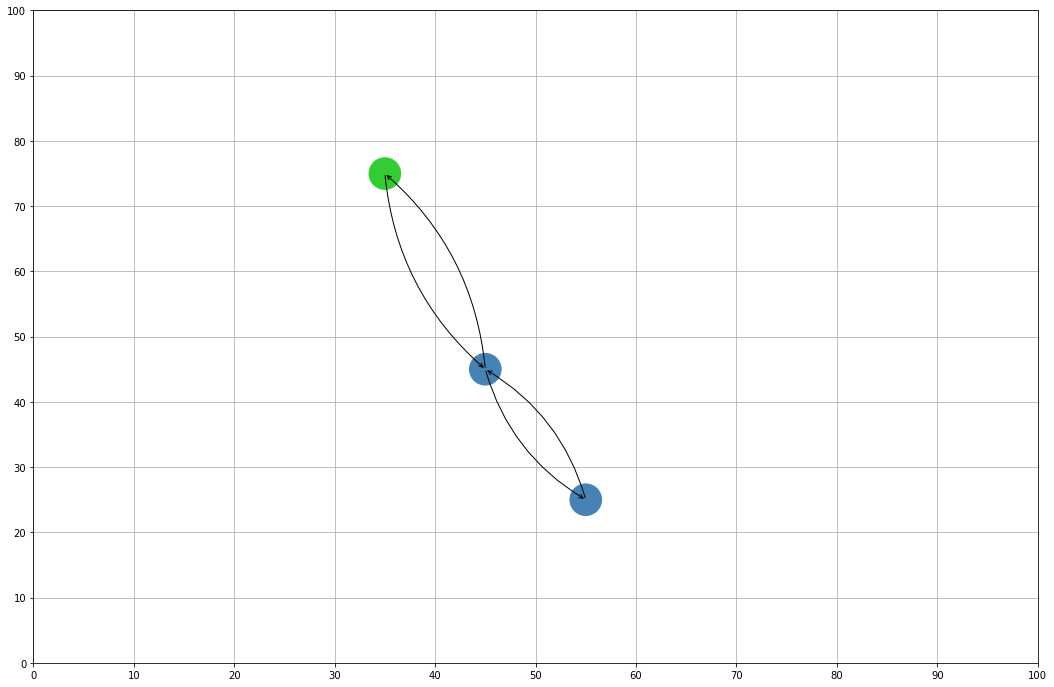

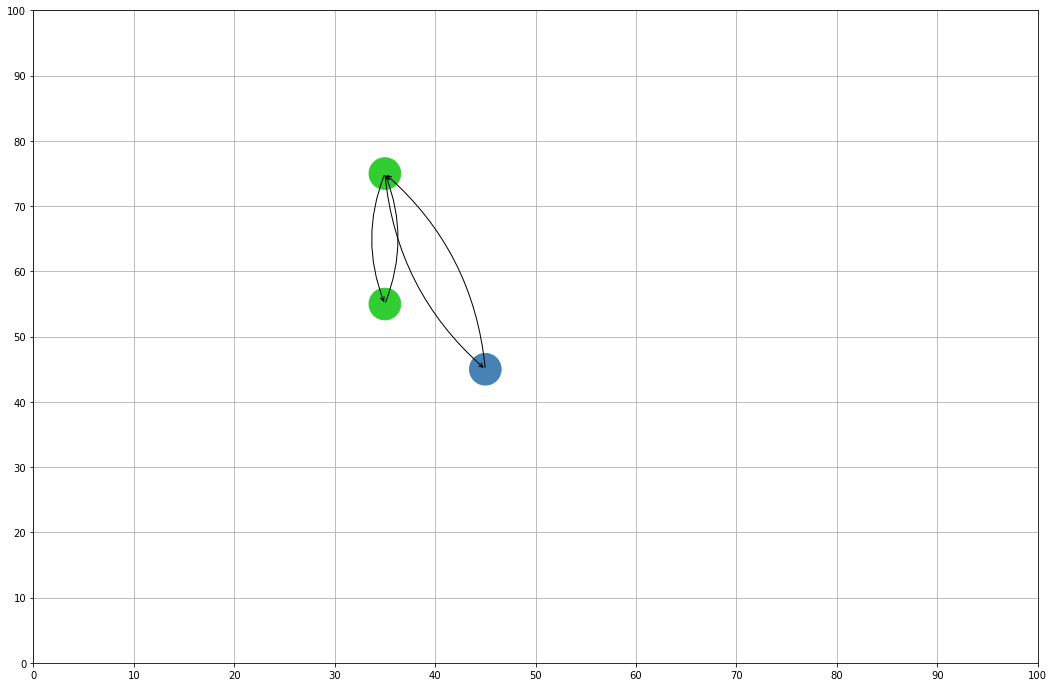

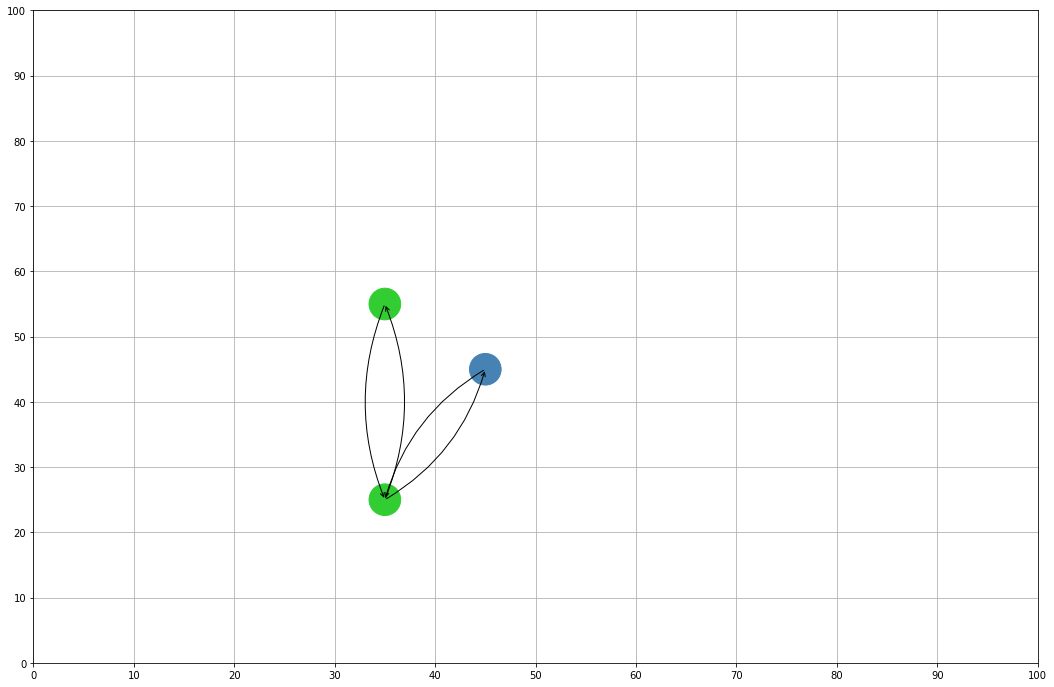

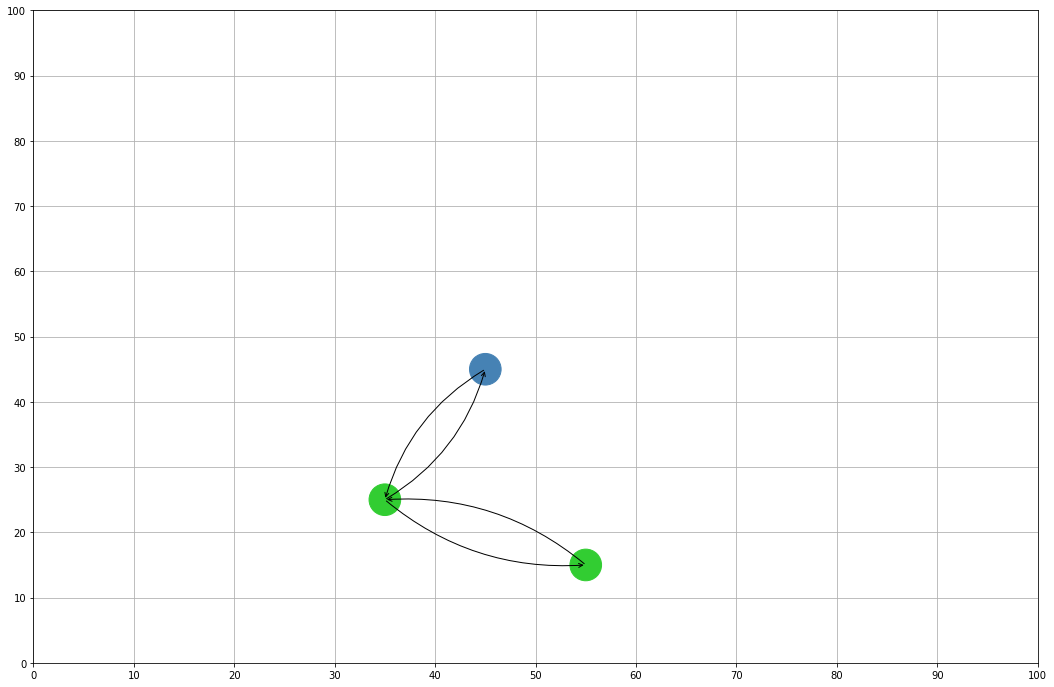

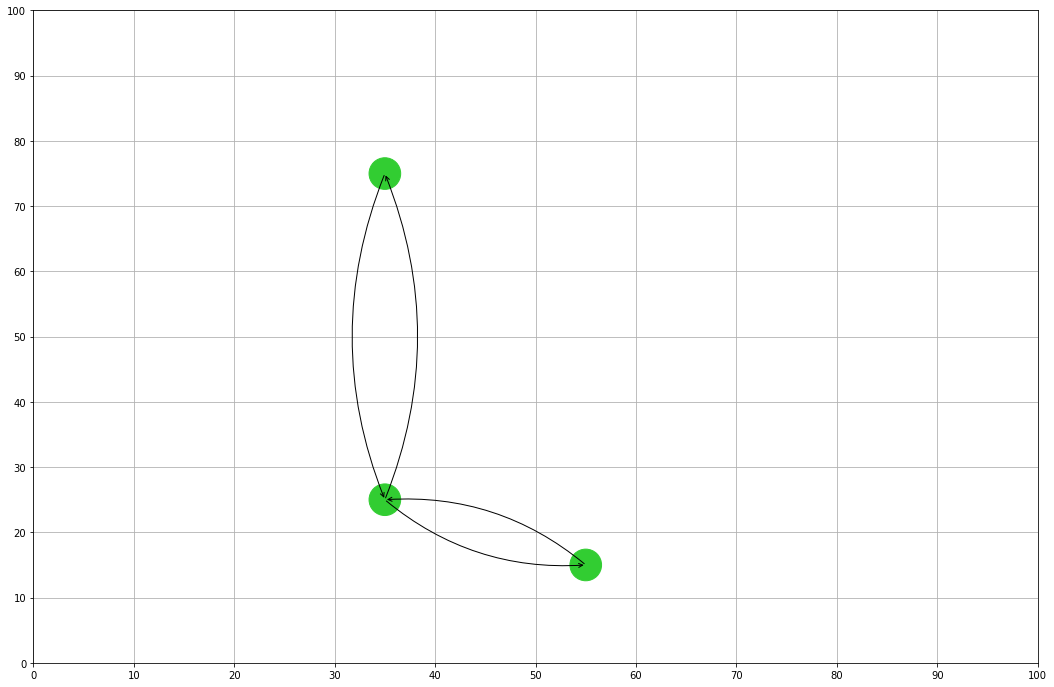

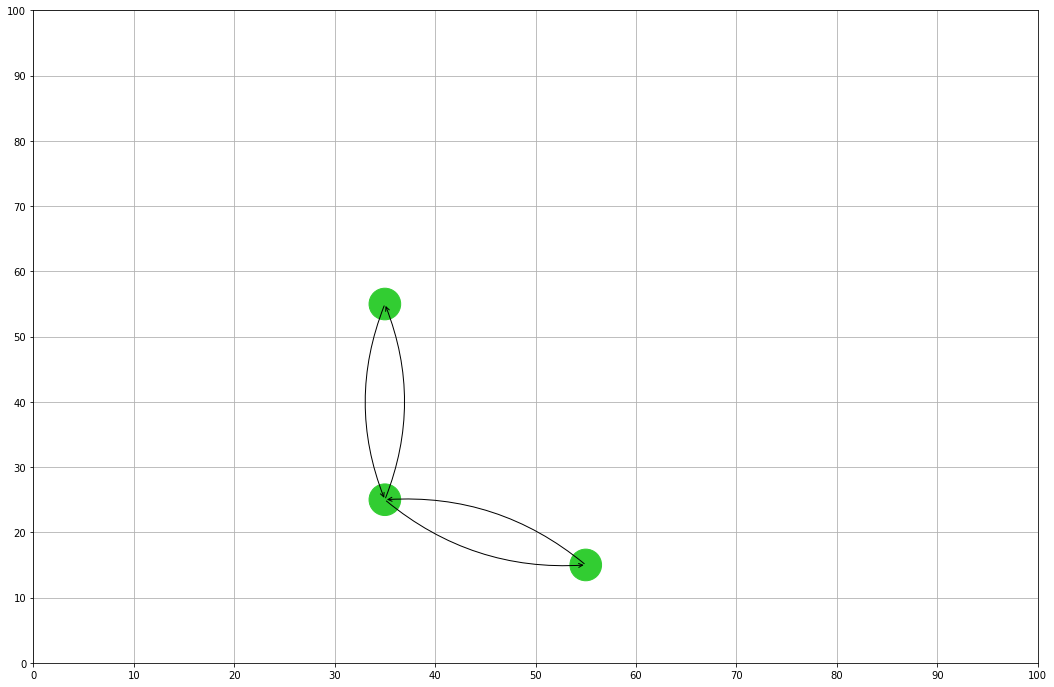

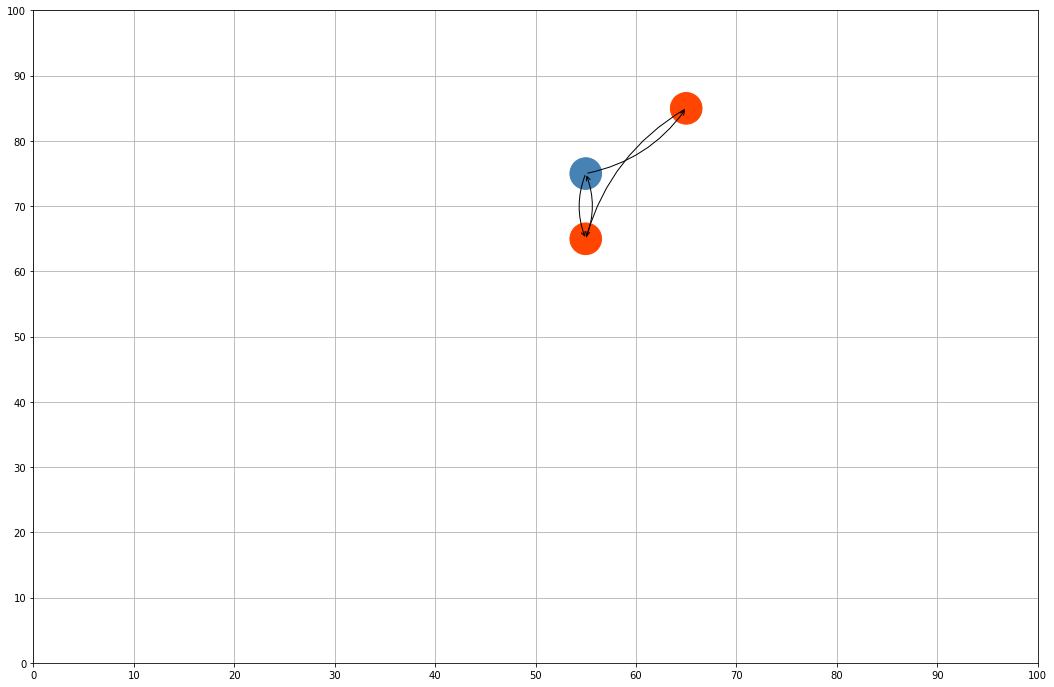

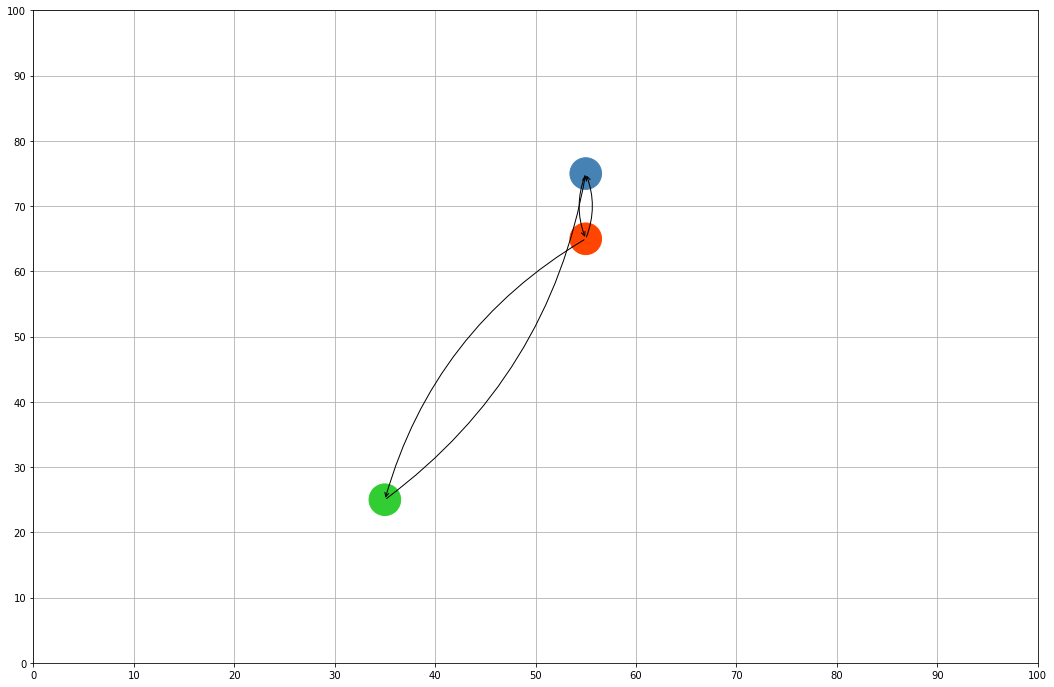

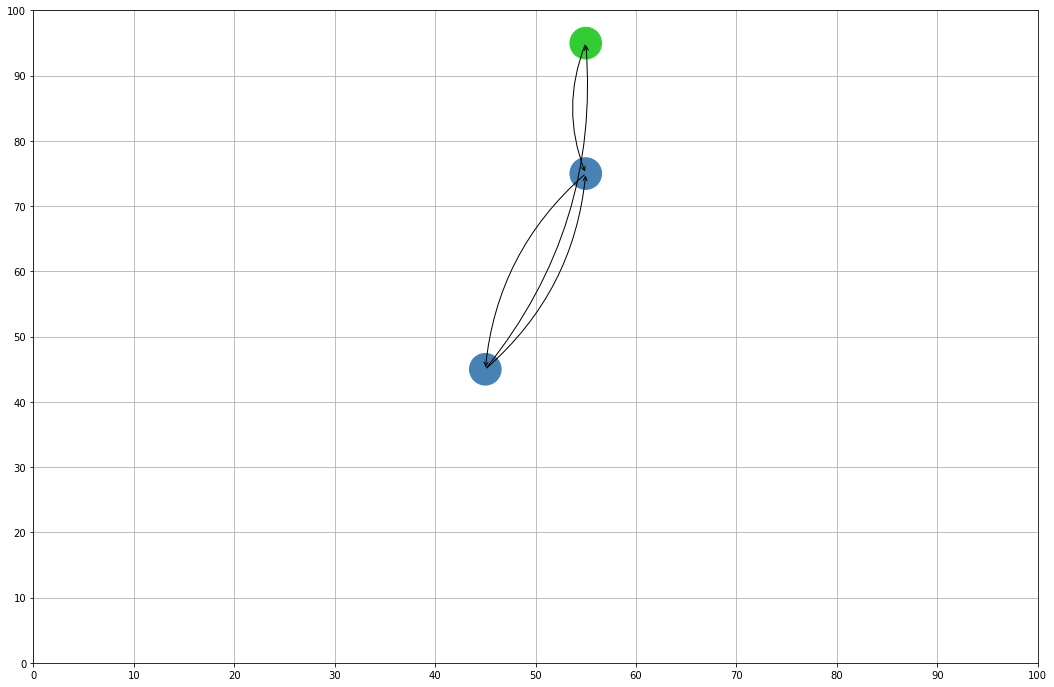

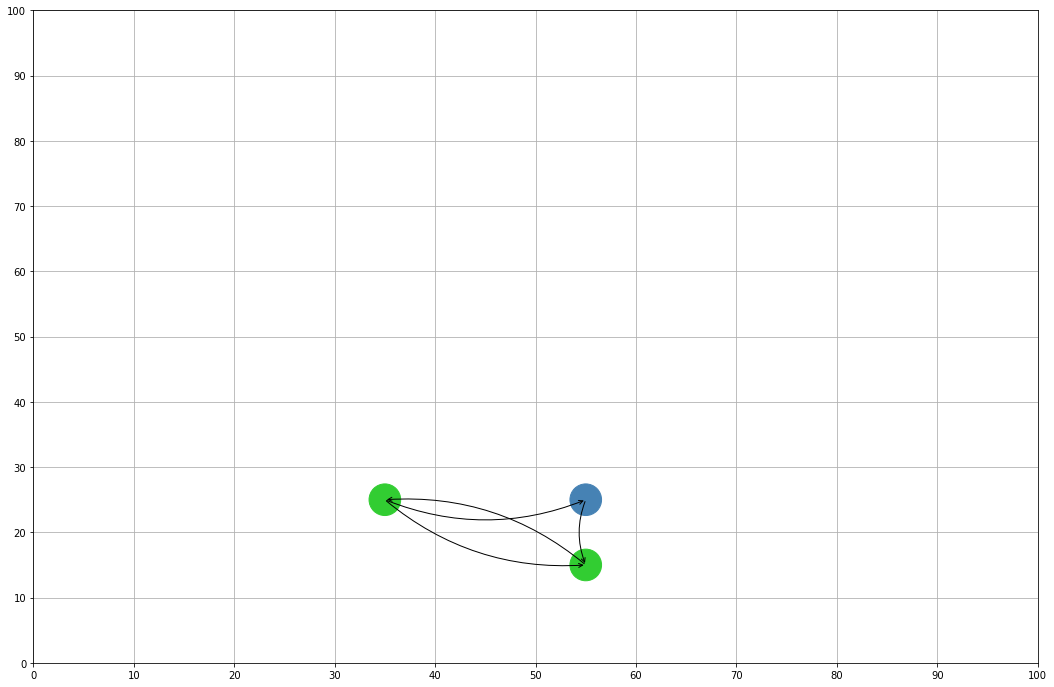

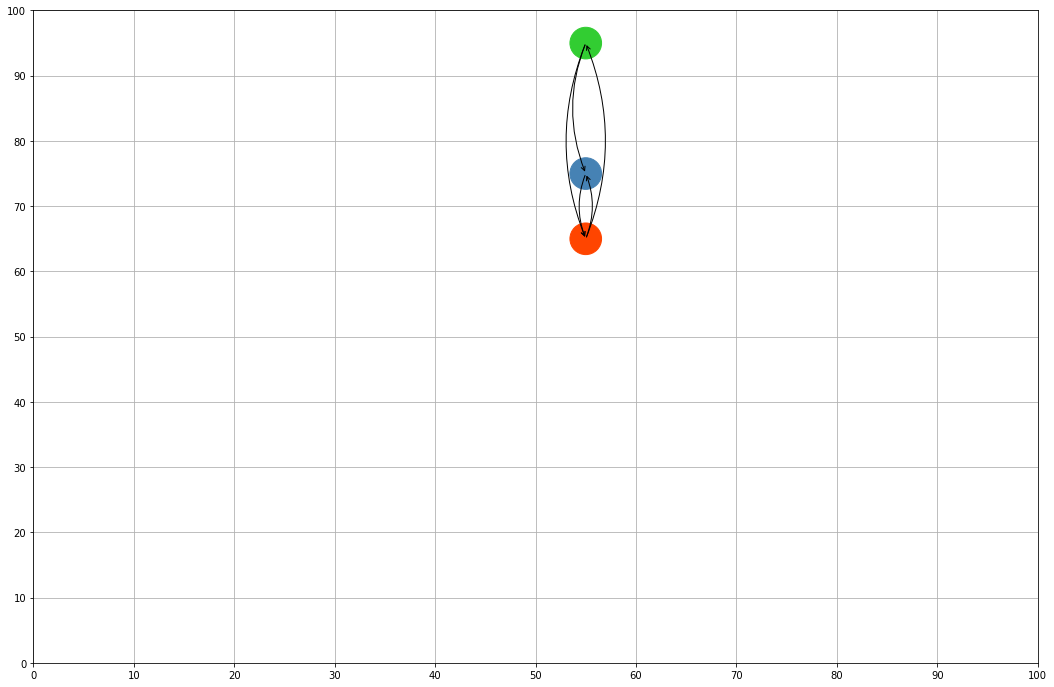

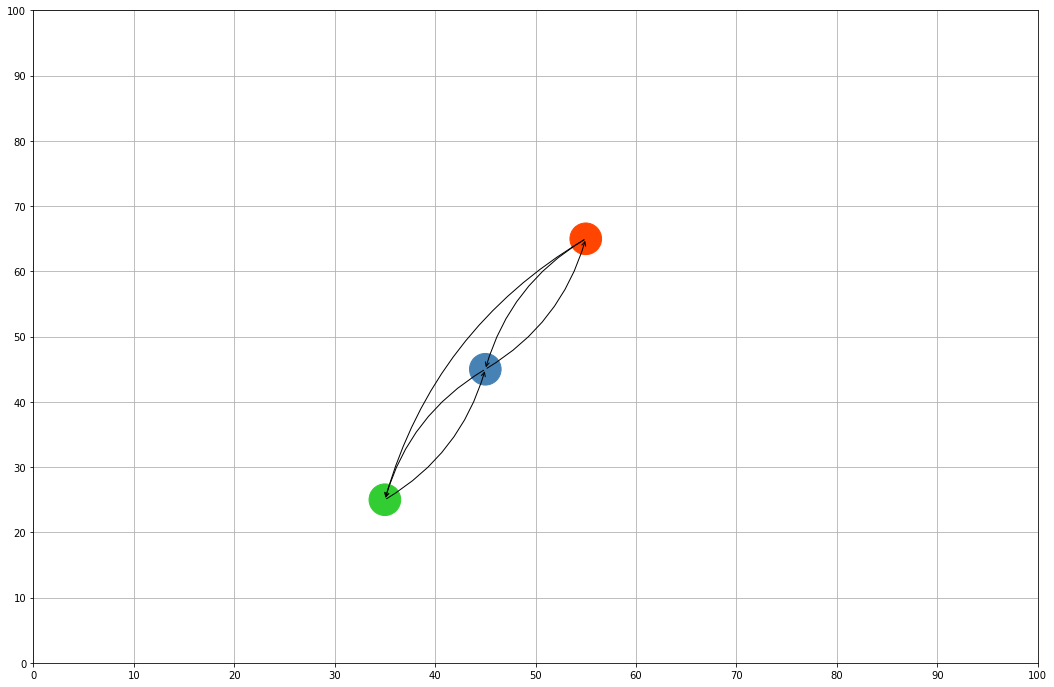

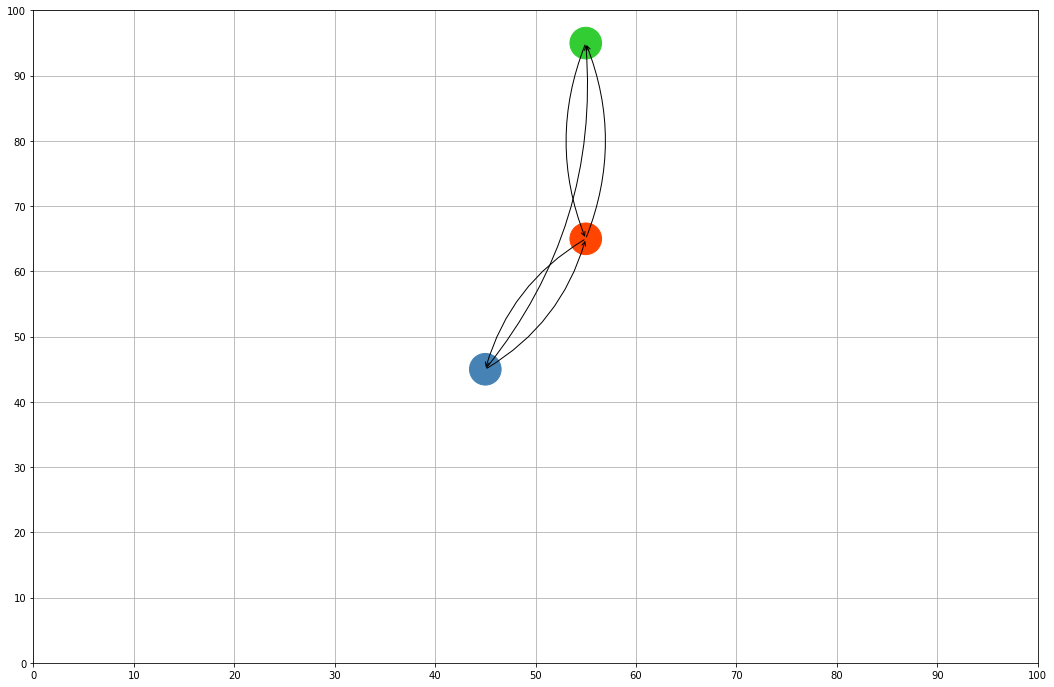

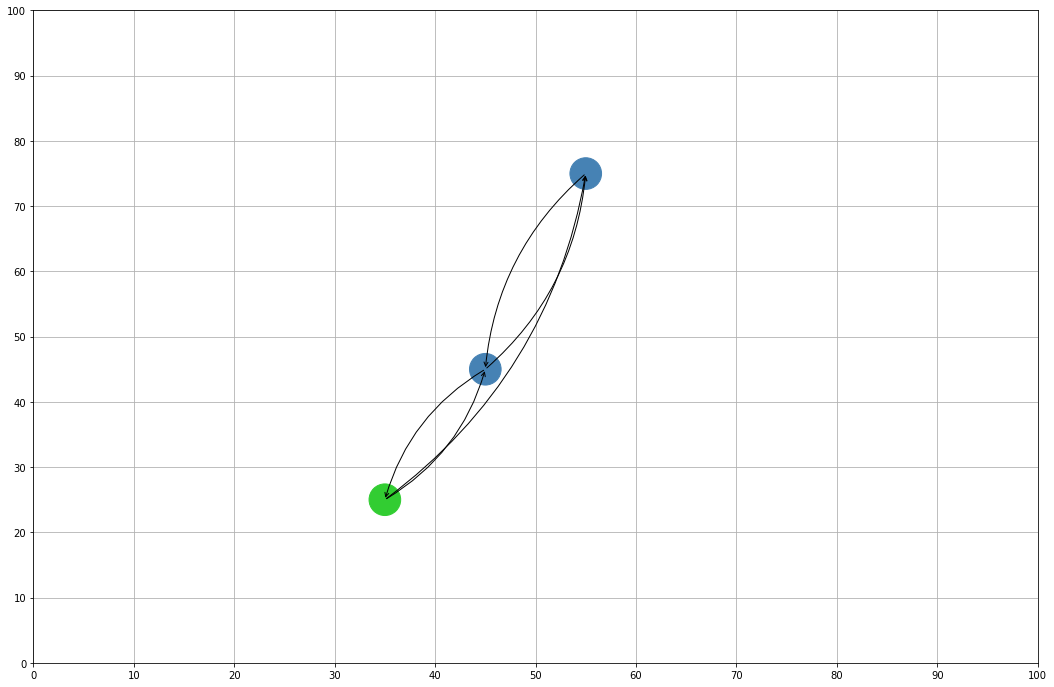

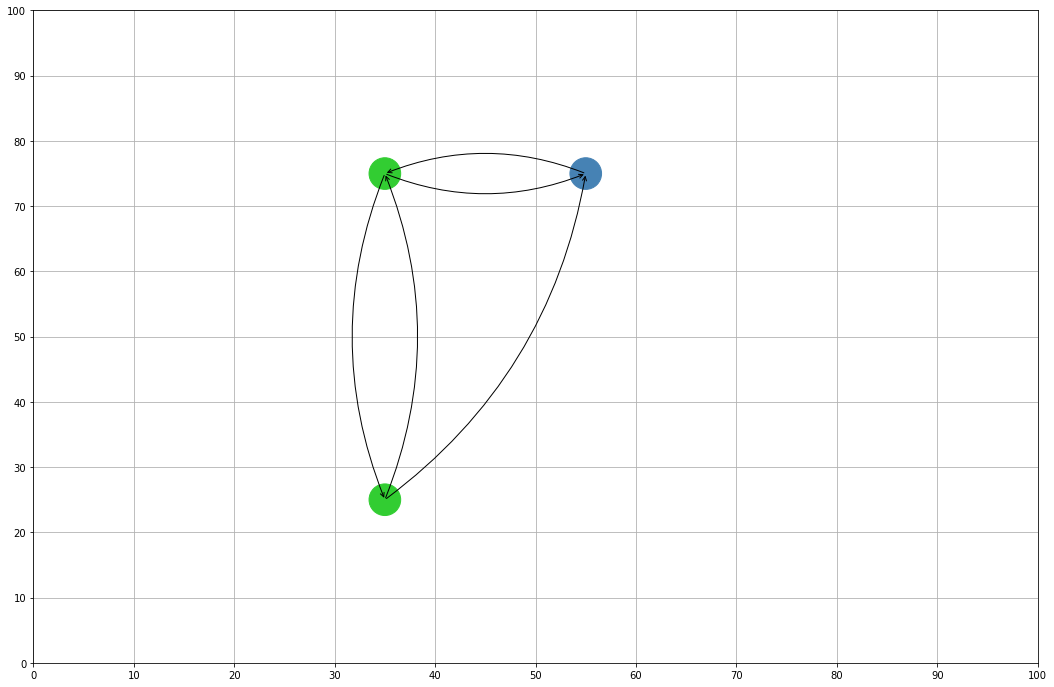

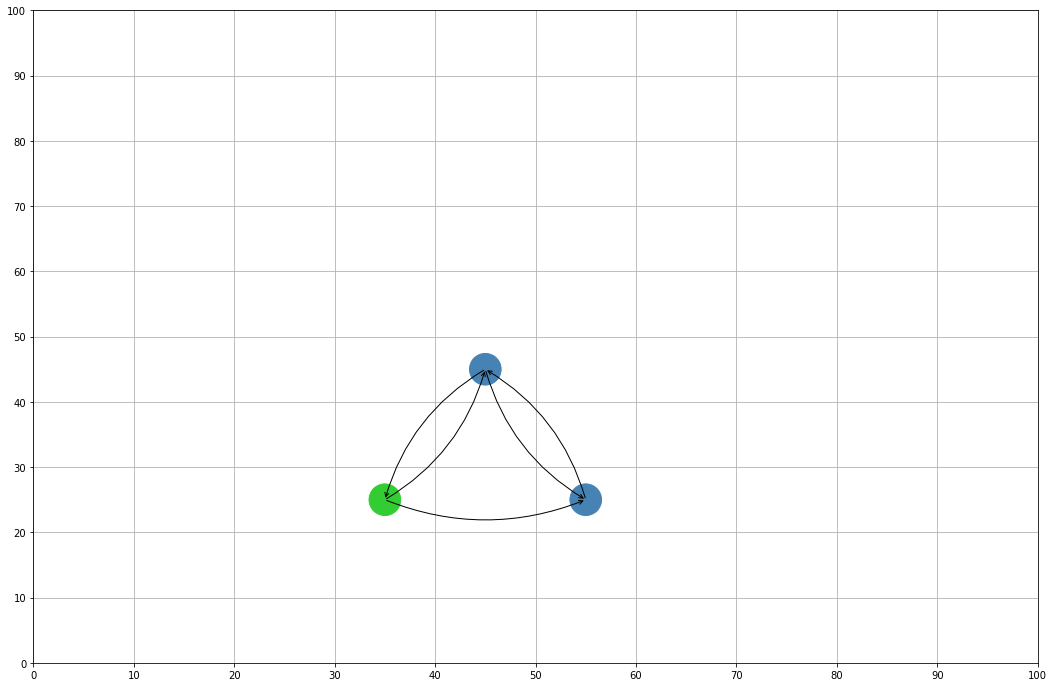

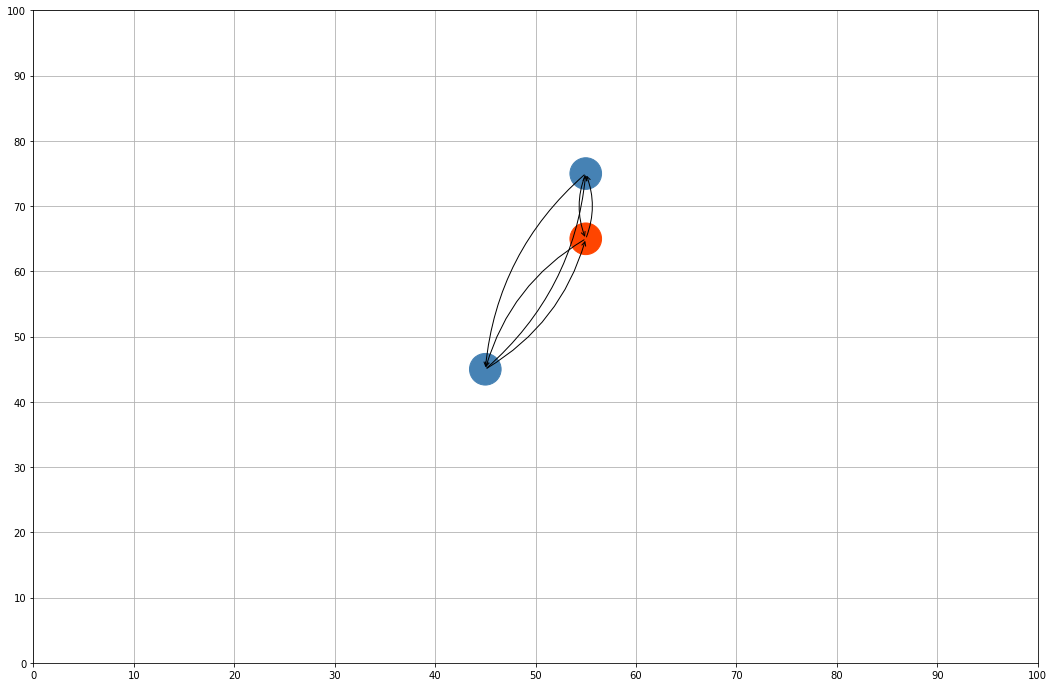

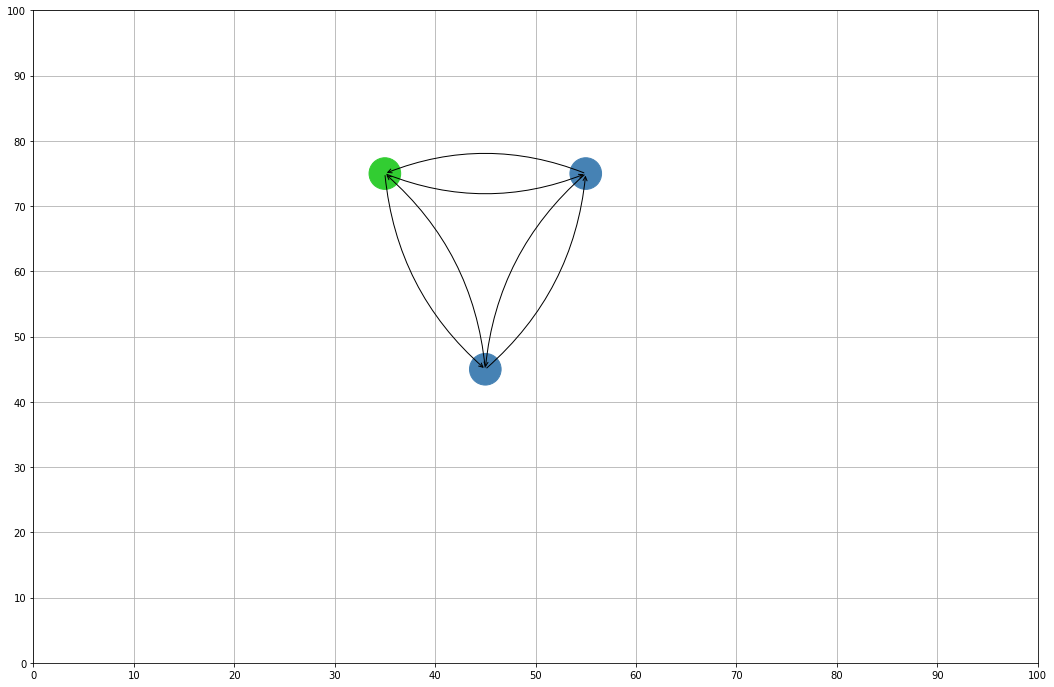

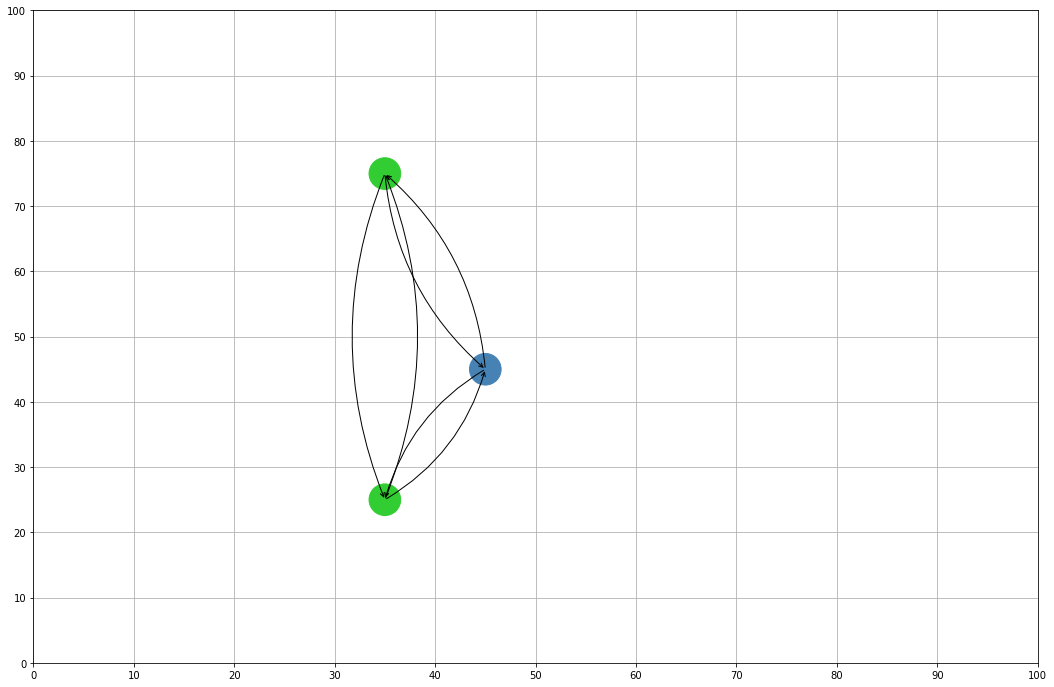

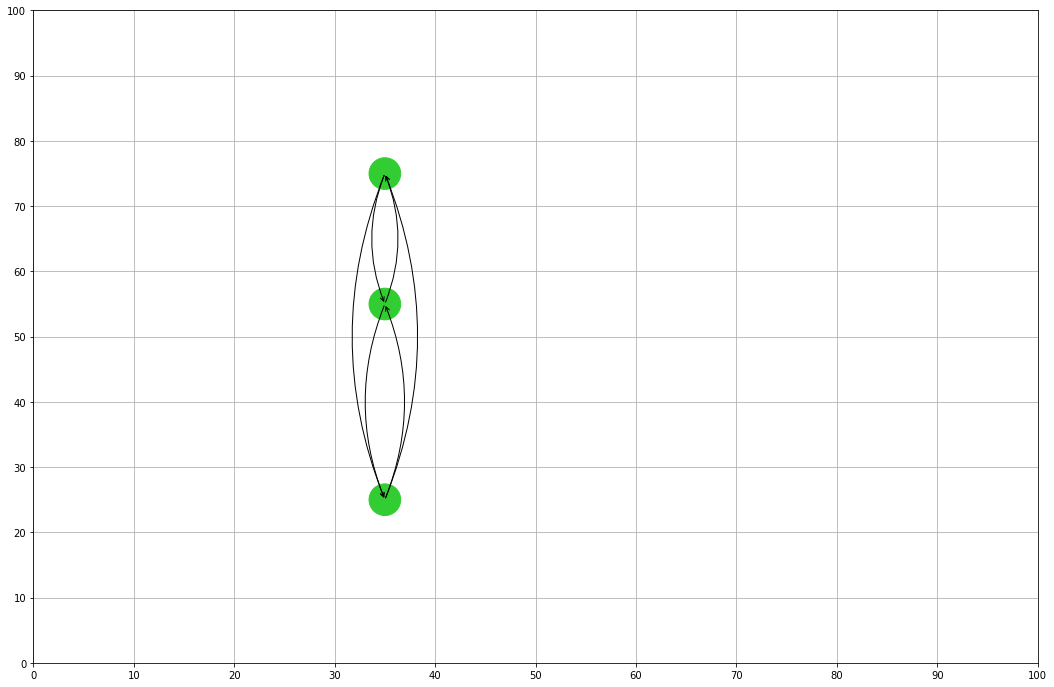

In [431]:
for claz,modes in m1_modes.items():
    for index in range(len(modes)):
        m,_,p1,p2,p3 = modes[index]
        ps = [p1,p2,p3]
        plt.figure(figsize=(18,12))
        plt.xticks(range(0,101,10))
        plt.yticks(range(0,101,10))
        plt.xlim(0,100)
        plt.ylim(0,100)
        avg_x = []
        avg_y = []
        c = []
        for p in ps:
            x, y = 0,0
            count = 0
            for i in range(len(team_pe)):
                if team_pe.iloc[i]['OriginPlayerID'] == p:
                    x += team_pe.iloc[i]['EventOrigin_x']
                    y += team_pe.iloc[i]['EventOrigin_y']
                    count += 1
                if team_pe.iloc[i]['DestinationPlayerID'] == p:
                    x += team_pe.iloc[i]['EventDestination_x']
                    y += team_pe.iloc[i]['EventDestination_y']
                    count += 1
            x /= count
            y /= count
            avg_x.append(np.floor(x/10))
            avg_y.append(np.floor(y/10))

            if 'F' in p:
                c.append('orangered')
            elif 'M' in p:
                c.append('steelblue')
            elif 'D' in p:
                c.append('limegreen')
            else:
                c.append('darkgrey')
        for i in range(3):
            for j in range(3):
                if m[i,j] == 1:
                    plt.annotate('', xy=(avg_x[j]*10+5,avg_y[j]*10+5),
                                 xytext=(avg_x[i]*10+5,avg_y[i]*10+5),
                        arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2'))
        plt.scatter(np.array(avg_x)*10+5,np.array(avg_y)*10+5,s=1000,c=c)
        plt.grid()
        plt.savefig('./trible/type%d_%d.png'%(claz,index), format='png', bbox_inches='tight', transparent=True, dpi=300)

In [419]:
t2 = Image.open("timg.png")
t1 = Image.open("test.png").resize((t2.size[0]-17,t2.size[1]-22),Image.ANTIALIAS)
t2.paste(t1,(2,15),t1)
t2.save('aa.png')
# NewImage.paste(temp,(((i//4)+1)*Single_width,(i%4)*Single_height),temp)

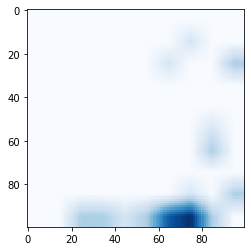

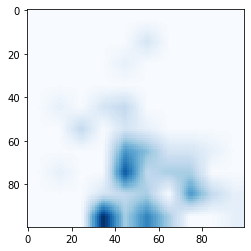

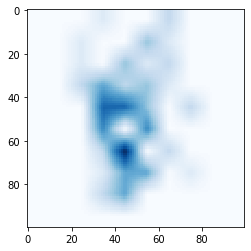

In [333]:
team_pe = unified_pe[(unified_pe.MatchID==1)]
avg_x = []
avg_y = []
for p in ps:
    x, y = 0,0
    heatmap = np.zeros(shape=(10,10))
    count = 0
    for i in range(len(team_pe)):
        if team_pe.iloc[i]['OriginPlayerID'] == p:
            x += team_pe.iloc[i]['EventOrigin_x']
            y += team_pe.iloc[i]['EventOrigin_y']
            heatmap[team_pe.iloc[i]['EventOrigin_y'],team_pe.iloc[i]['EventOrigin_x']] += 1
            count += 1
        if team_pe.iloc[i]['DestinationPlayerID'] == p:
            x += team_pe.iloc[i]['EventDestination_x']
            y += team_pe.iloc[i]['EventDestination_y']
            heatmap[team_pe.iloc[i]['EventDestination_y'],team_pe.iloc[i]['EventDestination_x']] += 1
            count += 1
    x /= count
    y /= count
    avg_x.append(x)
    avg_y.append(y)
    heatmap /= np.max(heatmap)
    pic = cv2.resize(cv2.imread('timg.PNG'),(100,100))
    heatmap = cv2.resize(heatmap, (pic.shape[1], pic.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_WINTER)
    plt.imshow(heatmap[:,:,0]*0.5,cmap='Blues_r')
    plt.show()
#     plt.imshow(superimposed_img)
#     cv2.imwrite('res\\%s\\%s_output.png'%(name, layer_name.split('/')[-1]), superimposed_img)

In [296]:
print(avg_x)
print(avg_y)

[6.4, 4.776699029126213, 4.182926829268292]
[7.6, 7.135922330097087, 4.426829268292683]


In [362]:
unified_pe[(unified_pe.MatchID==1)].groupby(["OriginPlayerID","DestinationPlayerID"]).get_group(('Huskies_D1','Huskies_D2')).mean()

MatchID                  1.000000
EventTime             1245.785543
EventOrigin_x            2.714286
EventOrigin_y            8.000000
EventDestination_x       2.642857
EventDestination_y       5.000000
dtype: float64

In [ ]:
m1 = pd.DataFrame(data=m1.T,index=p1,columns=p1)
m1.to_csv('mt.csv')